<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/i_jpea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import timm
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Step 1. Image Patching

In [ ]:
def patchify(images, patch_size):
    """
    Splits a batch of images into non-overlapping patches.
    Args:
      images: Tensor of shape (B, C, H, W)
      patch_size: Size of each square patch.
    Returns:
      Tensor of shape (B, num_patches, C, patch_size, patch_size)
    """
    B, C, H, W = images.shape
    assert H % patch_size == 0 and W % patch_size == 0, "H and W must be divisible by patch_size"
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # Use unfold to extract patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, -1, patch_size, patch_size)
    # Rearrange to (B, num_patches, C, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    return patches

# Step 2. Define the Encoders (Target & Context)

In [ ]:
class SimpleEncoder(nn.Module):
    """
    A simple CNN-based encoder to mimic a Vision Transformer patch encoder.
    In practice, a full ViT is used.
    """
    def __init__(self, in_channels=3, embed_dim=256):
        super(SimpleEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),  # reduce resolution
            nn.ReLU(),
            nn.Conv2d(64, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.AdaptiveAvgPool2d(1)  # output shape: (B, embed_dim, 1, 1)
        )

    def forward(self, x):
        # x: (B, C, patch_size, patch_size)
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # (B, embed_dim)

In [ ]:
# Instantiate target and context encoders.
target_encoder = SimpleEncoder()
context_encoder = SimpleEncoder()

# Step 3. Masking Strategy: Sample Target and Context Blocks

In [ ]:
def generate_masks(num_patches, target_block_count=4):
    """
    For simplicity, assume the patches are arranged in a square grid.
    This function randomly selects target blocks and one context patch.
    In a full implementation, target blocks would span multiple contiguous patches.
    Args:
      num_patches: Total number of patches per image.
      target_block_count: Number of target blocks to sample.
    Returns:
      target_masks: List of lists containing patch indices (simulated as (row, col) tuples)
      context_mask: A single (row, col) tuple representing the context block.
    """
    grid_size = int(num_patches ** 0.5)  # assuming a perfect square grid
    patch_indices = [(i, j) for i in range(grid_size) for j in range(grid_size)]

    # Sample target blocks (each represented here as a single patch for simplicity)
    target_masks = []
    for _ in range(target_block_count):
        target_masks.append([random.choice(patch_indices)])

    # Choose one patch for context that does not overlap with any target patch.
    target_set = {idx for mask in target_masks for idx in mask}
    remaining = [idx for idx in patch_indices if idx not in target_set]
    context_mask = random.choice(remaining) if remaining else None
    return target_masks, context_mask

# Step 4. Context Encoding

# Step 5. Prediction: Predictor Network

In [ ]:
class Predictor(nn.Module):
    """
    A simple MLP predictor that takes the context encoder's output (combined with a learnable mask token)
    and predicts the target representation.
    """
    def __init__(self, embed_dim=256):
        super(Predictor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        # A learnable mask token (shared across target blocks)
        self.mask_token = nn.Parameter(torch.randn(embed_dim))

    def forward(self, context_feat):
        # Combine context representation with the mask token (simple additive fusion)
        mask_token = self.mask_token.unsqueeze(0).expand(context_feat.size(0), -1)
        combined = context_feat + mask_token
        prediction = self.mlp(combined)
        return prediction

In [ ]:
predictor = Predictor()

# Step 6. Loss Computation

In [ ]:
def compute_loss(predicted, target):
    """
    Computes the L2 loss (mean squared error) between predicted and actual target representations.
    Args:
      predicted: Tensor of shape (B, embed_dim)
      target: Tensor of shape (B, embed_dim)
    Returns:
      Scalar loss.
    """
    return F.mse_loss(predicted, target)

# Step 7. EMA Update for Target Encoder

In [ ]:
def update_ema(context_encoder, target_encoder, ema_decay=0.99):
    """
    Updates target encoder parameters as an exponential moving average of context encoder parameters.
    """
    for param_c, param_t in zip(context_encoder.parameters(), target_encoder.parameters()):
        param_t.data = ema_decay * param_t.data + (1 - ema_decay) * param_c.data

# Putting It All Together: Training Step

In [ ]:
def training_step(images, patch_size=8, target_block_count=4):
    """
    A single training step that simulates the I-JEPA procedure.
    Args:
      images: Tensor of shape (B, 3, H, W)
    Returns:
      loss: Scalar loss value.
    """
    patch_size = 32  # Example: for 224x224 images, this yields a 7x7 patch grid.
    patches = patchify(images, patch_size)  # (B, num_patches, C, patch_size, patch_size)
    B, num_patches, C, ph, pw = patches.shape

    # Flatten patches and encode them with the target encoder.
    patches_flat = patches.view(B * num_patches, C, ph, pw)
    target_feats = target_encoder(patches_flat)  # (B*num_patches, embed_dim)
    target_feats = target_feats.view(B, num_patches, -1)  # (B, num_patches, embed_dim)

    total_loss = torch.tensor(0.0, requires_grad=True, device=images.device)
    # Process each image in the batch individually.
    for i in range(B):
        # Generate masks for target and context.
        target_masks, context_mask = generate_masks(num_patches, target_block_count=4)
        if context_mask is None:
            continue  # Skip if no valid context patch is available.

        # Convert the (row, col) index to a flat index.
        grid_size = int(num_patches ** 0.5)
        context_index = context_mask[0] * grid_size + context_mask[1]
        # Encode the selected context patch using the context encoder.
        context_patch = patches[i, context_index]  # (C, ph, pw)
        context_feat = context_encoder(context_patch.unsqueeze(0))  # (1, embed_dim)

        # For each target block, get the target representation and predict it.
        for mask in target_masks:
            # Here, each target block is simplified as one patch.
            t_row, t_col = mask[0]
            target_index = t_row * grid_size + t_col
            target_rep = target_feats[i, target_index].unsqueeze(0)  # (1, embed_dim)

            # Predictor takes context feature and predicts the target representation.
            predicted_rep = predictor(context_feat)
            total_loss += compute_loss(predicted_rep, target_rep)

    # Average loss over the batch.
    loss = total_loss / B
    return loss

# Example Training Loop

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # CIFAR-10 normalization (applied per-channel)
    ])
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-3)


In [ ]:
num_epochs = 5

In [ ]:
for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (images, _) in enumerate(train_loader):
            loss = training_step(images, patch_size=8, target_block_count=4)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            update_ema(context_encoder, target_encoder, ema_decay=0.99)

            running_loss += loss.item()
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss / 100:.8f}")
                running_loss = 0.0

# Another implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Available Devices:{device}")

Available Devices:cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. ViT-based encoder definition.

In [ ]:
def get_vit_encoder():
    model = vit_b_16(pretrained=False)
    model.heads = nn.Identity()  # Remove classification head.
    return model

# 2. Predictor network definition.

In [ ]:
class Predictor(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=768, num_targets=4):
        super(Predictor, self).__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape to [B, num_targets, output_dim]
        pred = pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)
        return pred

# 3. EMA update function.

In [ ]:
@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1 - beta)

# 4. Data augmentation: extract context and target blocks.

In [ ]:
def extract_blocks_v01(image, context_scale=0.85, target_scale=0.2, num_targets=4):
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = TF.crop(image, top, left, context_size, context_size)
    context_block = TF.resize(context_block, (224, 224))

    target_blocks = []
    target_size = int(target_scale * H)
    for _ in range(num_targets):
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = TF.crop(image, top_t, left_t, target_size, target_size)
        target_block = TF.resize(target_block, (224, 224))
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks

In [ ]:
def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    """
    Extract a context block and multiple target blocks from an image with controlled overlap.

    Args:
        image (torch.Tensor): Input image with shape (C, H, W).
        context_scale (float): Scale factor for the context block size relative to image height.
        target_scale (float): Scale factor for the target block size relative to image height.
        num_targets (int): Number of target blocks to extract.
        max_overlap (float): Maximum allowed overlap fraction between target and context blocks.

    Returns:
        tuple: (context_block, target_blocks, context_pos, target_positions), where
               - context_block: tensor of shape (C, 224, 224)
               - target_blocks: tensor of shape (num_targets, C, 224, 224)
               - context_pos: tuple (top, left, size)
               - target_positions: list of tuples [(top_t, left_t, size_t), ...]
    """
    _, H, W = image.shape

    # Extract context block from the center
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = TF.crop(image, top, left, context_size, context_size)
    context_block = TF.resize(context_block, (224, 224))
    context_pos = (top, left, context_size)

    # Extract target blocks with overlap constraint
    target_blocks = []
    target_positions = []
    target_size = int(target_scale * H)
    for _ in range(num_targets):
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        '''print(f"inside target generations")
        while True:
            top_t = random.randint(0, H - target_size)
            left_t = random.randint(0, W - target_size)
            # Calculate overlap with context block
            overlap_height = max(0, min(top + context_size, top_t + target_size) - max(top, top_t))
            overlap_width = max(0, min(left + context_size, left_t + target_size) - max(left, left_t))
            overlap_area = overlap_height * overlap_width
            target_area = target_size ** 2
            overlap_fraction = overlap_area / target_area if target_area > 0 else 0
            print(f"overlap_fraction ({overlap_fraction}) <> max_overlap ({max_overlap})")
            if overlap_fraction <= max_overlap:
                print(f"overlap_fraction ({overlap_fraction}) <= max_overlap ({max_overlap})")
                break
        print(f"outside target generations")'''
        target_block = TF.crop(image, top_t, left_t, target_size, target_size)
        target_block = TF.resize(target_block, (224, 224))
        target_blocks.append(target_block)
        target_positions.append((top_t, left_t, target_size))

    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, context_pos, target_positions

In [ ]:
def visualize_context_target(dataloader, n=10, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    """
    Selects n random images from the dataloader and draws:
      - A red rectangle representing the context block (center crop).
      - Blue rectangles representing the target blocks (random crops).

    Parameters:
      dataloader (DataLoader): A PyTorch DataLoader containing images (after transforms).
      n (int): Number of images to visualize.
      context_scale (float): Fraction of image height to use for the context block.
      target_scale (float): Fraction of image height to use for each target block.
      num_targets (int): Number of target blocks to draw.
      max_overlap (float): Maximum allowed overlap fraction between target and context blocks.
    """
    # Get one full batch from the dataloader
    images = []
    for batch in dataloader:
        images = batch[0]  # shape: [B, C, H, W], assuming batch[0] is the image tensor
        break  # use only the first batch

    # Randomly choose n images from the batch (if batch size < n, use all)
    n = min(n, images.size(0))
    indices = random.sample(range(images.size(0)), n)

    for idx in indices:
        # Get the image tensor and convert to numpy for plotting
        img_tensor = images[idx]  # shape: [C, H, W]
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()  # shape: [H, W, C], assuming values in [0,1]
        H, W, _ = img_np.shape

        # Extract blocks and their positions using extract_blocks
        context_block, target_blocks, context_pos, target_positions = extract_blocks(
            img_tensor,
            context_scale=context_scale,
            target_scale=target_scale,
            num_targets=num_targets,
            max_overlap=max_overlap
        )

        # Plot the image
        fig, ax = plt.subplots(1)
        ax.imshow(img_np)

        # Draw context rectangle in red
        top, left, size = context_pos
        rect_context = patches.Rectangle(
            (left, top), size, size,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect_context)

        # Draw each target rectangle in blue
        for top_t, left_t, size_t in target_positions:
            rect_target = patches.Rectangle(
                (left_t, top_t), size_t, size_t,
                linewidth=2, edgecolor='blue', facecolor='none'
            )
            ax.add_patch(rect_target)

        ax.set_title("Red: Context Block | Blue: Target Blocks")
        plt.axis('off')
        plt.show()

In [ ]:
visualize_context_target(train_loader)

# 5. Custom dataset wrapping CIFAR-10.

In [ ]:
class IJEPADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, context_scale=0.85, target_scale=0.2, num_targets=4):
        self.dataset = dataset
        self.context_scale = context_scale
        self.target_scale = target_scale
        self.num_targets = num_targets
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        context_block, target_blocks,  _, _  = extract_blocks(image, self.context_scale, self.target_scale, self.num_targets)
        return context_block, target_blocks, label

# 6. Dataset preparation with train/val/test split.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),

])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
train_ijepa_dataset = IJEPADataset(train_dataset)
val_ijepa_dataset = IJEPADataset(val_dataset)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_ijepa_dataset = IJEPADataset(test_dataset)

train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ijepa_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ijepa_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 71.0MB/s]


# 7. Initialize models, optimizer, and loss.

In [ ]:
context_encoder = get_vit_encoder().to(device)
target_encoder = get_vit_encoder().to(device)
target_encoder.load_state_dict(context_encoder.state_dict())

predictor = Predictor(input_dim=768, hidden_dim=768, output_dim=768, num_targets=4).to(device)

optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
criterion = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# 8. Training loop with validation and loss recording.

In [ ]:
num_epochs = 100
ema_decay = 0.99

train_losses = []
val_losses = []

# Debug output included for Training loop with validation and loss recording.

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

for epoch in range(num_epochs):
    # Start epoch timer.
    epoch_start_time = time.time()

    # -------------------------------
    # Training Phase
    # -------------------------------
    context_encoder.train()
    predictor.train()
    epoch_train_loss = 0.0
    train_start_time = time.time()

    for context_block, target_blocks, _ in tqdm(train_loader,
                                                 desc=f"Train Epoch {epoch+1}/{num_epochs}",
                                                 leave=False):
        context_block = context_block.to(device)             # [B, C, 224, 224]
        target_blocks = target_blocks.to(device)               # [B, num_targets, C, 224, 224]

        # Forward pass: extract context representation and predict target representations.
        context_repr = context_encoder(context_block)          # [B, 768]
        preds = predictor(context_repr)                        # [B, num_targets, 768]

        # Flatten target blocks and compute target encoder representations.
        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)  # [B*num_targets, 768]
        target_repr = target_repr_flat.view(B, num_targets, -1)

        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema(context_encoder, target_encoder, ema_decay)

        epoch_train_loss += loss.item() * context_block.size(0)

    train_time = time.time() - train_start_time
    epoch_train_loss /= len(train_ijepa_dataset)
    train_losses.append(epoch_train_loss)

    # -------------------------------
    # Validation Phase
    # -------------------------------
    context_encoder.eval()
    predictor.eval()
    epoch_val_loss = 0.0
    val_start_time = time.time()

    with torch.no_grad():
        for context_block, target_blocks, _ in tqdm(val_loader,
                                                     desc=f"Val Epoch {epoch+1}/{num_epochs}",
                                                     leave=False):
            context_block = context_block.to(device)
            target_blocks = target_blocks.to(device)

            context_repr = context_encoder(context_block)
            preds = predictor(context_repr)

            B, num_targets, C, Ht, Wt = target_blocks.shape
            target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
            target_repr_flat = target_encoder(target_blocks_flat)
            target_repr = target_repr_flat.view(B, num_targets, -1)

            loss = criterion(preds, target_repr)
            epoch_val_loss += loss.item() * context_block.size(0)

    val_time = time.time() - val_start_time
    epoch_val_loss /= len(val_ijepa_dataset)
    val_losses.append(epoch_val_loss)

    epoch_total_time = time.time() - epoch_start_time

    # -------------------------------
    # Epoch Summary
    # -------------------------------
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} Train Time: {train_time:.2f}s, Val Time: {val_time:.2f}s, Total Epoch Time: {epoch_total_time:.2f}s")
    torch.save(model_state, '/content/drive/MyDrive/SelfSupervise/i_jepa_model-2.pth')
    # -------------------------------
    # Visualization: Save Context & Target Block Representations for the first sample.
    # -------------------------------
    # Get the first batch from the training loader.
    '''first_batch = next(iter(train_loader))
    context_batch, target_batch, _ = first_batch
    # Extract the first sample (index 0).
    context_block_first = context_batch[0].cpu()   # shape: [C, 224, 224]
    target_blocks_first = target_batch[0].cpu()      # shape: [num_targets, C, 224, 224]

    # Compute representations for the first sample.
    with torch.no_grad():
        # Context representation: add batch dimension.
        context_repr_first = context_encoder(context_batch[0].unsqueeze(0).to(device))  # [1, 768]
        # For target blocks: add batch dimension (B=1) then flatten.
        target_blocks_first_device = target_batch[0].unsqueeze(0).to(device)  # [1, num_targets, C, 224, 224]
        B, num_targets, C, Ht, Wt = target_blocks_first_device.shape
        target_blocks_flat_first = target_blocks_first_device.view(B * num_targets, C, Ht, Wt)
        target_repr_first = target_encoder(target_blocks_flat_first)  # [num_targets, 768]

    # Visualize Context Block and its Representation.
    fig1, ax1 = plt.subplots(1, 2, figsize=(10, 5))
    # Original context block (transpose to H x W x C)
    ax1[0].imshow(context_block_first.permute(1, 2, 0))
    ax1[0].set_title("Context Block (Original)")
    ax1[0].axis("off")
    # Representation: reshape vector of size 768 to 24x32.
    context_repr_img = context_repr_first.squeeze(0).cpu().numpy().reshape(24, 32)
    im1 = ax1[1].imshow(context_repr_img, cmap="viridis")
    ax1[1].set_title("Context Representation")
    ax1[1].axis("off")
    fig1.colorbar(im1, ax=ax1[1])
    plt.suptitle(f"Epoch {epoch+1} - Context")
    plt.savefig(f"/content/drive/MyDrive/ijepa/trainContextTarget/context_epoch_{epoch+1}.png")
    plt.close(fig1)

    # Visualize Target Blocks and their Representations.
    num_targs = target_blocks_first.shape[0]
    fig2, axes = plt.subplots(num_targs, 2, figsize=(10, num_targs * 3))
    if num_targs == 1:
        axes = [axes]  # Make it iterable if only one target.
    for i in range(num_targs):
        # Original target block.
        tb_img = target_blocks_first[i]
        axes[i][0].imshow(tb_img.permute(1, 2, 0))
        axes[i][0].set_title(f"Target Block {i+1} (Original)")
        axes[i][0].axis("off")
        # Target representation: reshape 768-dim vector to 24x32 heatmap.
        tr_img = target_repr_first[i].cpu().numpy().reshape(24, 32)
        im2 = axes[i][1].imshow(tr_img, cmap="viridis")
        axes[i][1].set_title(f"Target Block {i+1} Representation")
        axes[i][1].axis("off")
        fig2.colorbar(im2, ax=axes[i][1])
    plt.suptitle(f"Epoch {epoch+1} - Target Blocks")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/ijepa/trainContextTarget/target_epoch_{epoch+1}.png")
    plt.close(fig2)'''


Epoch 1/100, Train Loss: 0.2580, Val Loss: 0.1893 Train Time: 781.19s, Val Time: 145.89s, Total Epoch Time: 927.09s


Epoch 2/100, Train Loss: 0.1597, Val Loss: 0.1408 Train Time: 779.54s, Val Time: 146.04s, Total Epoch Time: 925.58s


Epoch 3/100, Train Loss: 0.1468, Val Loss: 0.1520 Train Time: 779.25s, Val Time: 145.53s, Total Epoch Time: 924.78s


Epoch 4/100, Train Loss: 0.1067, Val Loss: 0.0839 Train Time: 779.52s, Val Time: 145.98s, Total Epoch Time: 925.50s


Epoch 5/100, Train Loss: 0.0616, Val Loss: 0.0288 Train Time: 779.91s, Val Time: 145.82s, Total Epoch Time: 925.73s


Epoch 6/100, Train Loss: 0.0259, Val Loss: 0.0258 Train Time: 780.14s, Val Time: 145.89s, Total Epoch Time: 926.02s


Epoch 7/100, Train Loss: 0.0337, Val Loss: 0.0414 Train Time: 779.84s, Val Time: 146.08s, Total Epoch Time: 925.92s


Epoch 8/100, Train Loss: 0.0330, Val Loss: 0.0369 Train Time: 780.67s, Val Time: 145.78s, Total Epoch Time: 926.46s


Epoch 9/100, Train Loss: 0.0425, Val Loss: 0.0491 Train Time: 780.17s, Val Time: 145.77s, Total Epoch Time: 925.95s


Epoch 10/100, Train Loss: 0.0448, Val Loss: 0.0465 Train Time: 780.16s, Val Time: 145.82s, Total Epoch Time: 925.99s


Epoch 11/100, Train Loss: 0.0415, Val Loss: 0.0380 Train Time: 780.22s, Val Time: 145.81s, Total Epoch Time: 926.03s


Epoch 12/100, Train Loss: 0.0357, Val Loss: 0.0432 Train Time: 780.27s, Val Time: 145.83s, Total Epoch Time: 926.11s


Epoch 13/100, Train Loss: 0.0356, Val Loss: 0.0323 Train Time: 780.51s, Val Time: 145.86s, Total Epoch Time: 926.37s


Epoch 14/100, Train Loss: 0.0310, Val Loss: 0.0327 Train Time: 780.29s, Val Time: 145.98s, Total Epoch Time: 926.28s


Epoch 15/100, Train Loss: 0.0250, Val Loss: 0.0187 Train Time: 780.52s, Val Time: 146.24s, Total Epoch Time: 926.76s


Epoch 16/100, Train Loss: 0.0190, Val Loss: 0.0159 Train Time: 780.04s, Val Time: 146.29s, Total Epoch Time: 926.33s


Epoch 17/100, Train Loss: 0.0168, Val Loss: 0.0178 Train Time: 780.14s, Val Time: 146.06s, Total Epoch Time: 926.20s


Epoch 18/100, Train Loss: 0.0141, Val Loss: 0.0141 Train Time: 780.80s, Val Time: 146.59s, Total Epoch Time: 927.38s


Epoch 19/100, Train Loss: 0.0146, Val Loss: 0.0156 Train Time: 781.43s, Val Time: 146.35s, Total Epoch Time: 927.78s


Epoch 20/100, Train Loss: 0.0141, Val Loss: 0.0086 Train Time: 780.53s, Val Time: 146.17s, Total Epoch Time: 926.70s


Epoch 21/100, Train Loss: 0.0074, Val Loss: 0.0085 Train Time: 781.08s, Val Time: 146.33s, Total Epoch Time: 927.41s


Epoch 22/100, Train Loss: 0.0092, Val Loss: 0.0068 Train Time: 781.61s, Val Time: 146.14s, Total Epoch Time: 927.75s


Epoch 23/100, Train Loss: 0.0052, Val Loss: 0.0046 Train Time: 780.15s, Val Time: 146.35s, Total Epoch Time: 926.50s


Epoch 24/100, Train Loss: 0.0073, Val Loss: 0.0093 Train Time: 781.12s, Val Time: 146.07s, Total Epoch Time: 927.19s


Epoch 25/100, Train Loss: 0.0089, Val Loss: 0.0081 Train Time: 780.62s, Val Time: 146.39s, Total Epoch Time: 927.02s


Epoch 26/100, Train Loss: 0.0086, Val Loss: 0.0069 Train Time: 780.29s, Val Time: 146.42s, Total Epoch Time: 926.71s


Epoch 27/100, Train Loss: 0.0071, Val Loss: 0.0067 Train Time: 781.06s, Val Time: 146.19s, Total Epoch Time: 927.25s


Epoch 28/100, Train Loss: 0.0067, Val Loss: 0.0072 Train Time: 781.18s, Val Time: 146.40s, Total Epoch Time: 927.58s


Epoch 29/100, Train Loss: 0.0071, Val Loss: 0.0065 Train Time: 780.58s, Val Time: 146.41s, Total Epoch Time: 926.99s


Epoch 30/100, Train Loss: 0.0063, Val Loss: 0.0058 Train Time: 780.49s, Val Time: 145.75s, Total Epoch Time: 926.24s


Epoch 31/100, Train Loss: 0.0066, Val Loss: 0.0081 Train Time: 780.71s, Val Time: 146.17s, Total Epoch Time: 926.88s


Epoch 32/100, Train Loss: 0.0075, Val Loss: 0.0057 Train Time: 780.50s, Val Time: 146.16s, Total Epoch Time: 926.67s


Epoch 33/100, Train Loss: 0.0048, Val Loss: 0.0046 Train Time: 780.46s, Val Time: 146.48s, Total Epoch Time: 926.94s


Epoch 34/100, Train Loss: 0.0051, Val Loss: 0.0053 Train Time: 780.87s, Val Time: 146.36s, Total Epoch Time: 927.23s


Epoch 35/100, Train Loss: 0.0044, Val Loss: 0.0033 Train Time: 781.43s, Val Time: 146.63s, Total Epoch Time: 928.06s


Epoch 36/100, Train Loss: 0.0028, Val Loss: 0.0022 Train Time: 781.40s, Val Time: 146.47s, Total Epoch Time: 927.88s


Epoch 37/100, Train Loss: 0.0021, Val Loss: 0.0019 Train Time: 781.46s, Val Time: 146.47s, Total Epoch Time: 927.93s


Epoch 38/100, Train Loss: 0.0019, Val Loss: 0.0018 Train Time: 780.90s, Val Time: 146.43s, Total Epoch Time: 927.33s


Epoch 39/100, Train Loss: 0.0019, Val Loss: 0.0021 Train Time: 780.48s, Val Time: 146.34s, Total Epoch Time: 926.82s


Epoch 40/100, Train Loss: 0.0026, Val Loss: 0.0028 Train Time: 782.44s, Val Time: 146.24s, Total Epoch Time: 928.68s


Epoch 41/100, Train Loss: 0.0028, Val Loss: 0.0035 Train Time: 781.01s, Val Time: 146.00s, Total Epoch Time: 927.02s


Epoch 42/100, Train Loss: 0.0031, Val Loss: 0.0030 Train Time: 781.16s, Val Time: 145.99s, Total Epoch Time: 927.15s


Epoch 43/100, Train Loss: 0.0032, Val Loss: 0.0033 Train Time: 781.71s, Val Time: 146.51s, Total Epoch Time: 928.22s


Epoch 44/100, Train Loss: 0.0032, Val Loss: 0.0032 Train Time: 780.99s, Val Time: 146.48s, Total Epoch Time: 927.47s


Epoch 45/100, Train Loss: 0.0030, Val Loss: 0.0031 Train Time: 781.55s, Val Time: 146.38s, Total Epoch Time: 927.93s


Epoch 46/100, Train Loss: 0.0034, Val Loss: 0.0032 Train Time: 781.02s, Val Time: 146.34s, Total Epoch Time: 927.36s


Epoch 47/100, Train Loss: 0.0026, Val Loss: 0.0025 Train Time: 782.12s, Val Time: 146.70s, Total Epoch Time: 928.82s


Epoch 48/100, Train Loss: 0.0026, Val Loss: 0.0028 Train Time: 781.52s, Val Time: 146.06s, Total Epoch Time: 927.59s


Epoch 49/100, Train Loss: 0.0022, Val Loss: 0.0014 Train Time: 781.61s, Val Time: 146.49s, Total Epoch Time: 928.10s


Epoch 50/100, Train Loss: 0.0012, Val Loss: 0.0012 Train Time: 781.18s, Val Time: 146.56s, Total Epoch Time: 927.75s


Epoch 51/100, Train Loss: 0.0013, Val Loss: 0.0015 Train Time: 781.37s, Val Time: 146.72s, Total Epoch Time: 928.09s


Epoch 52/100, Train Loss: 0.0016, Val Loss: 0.0014 Train Time: 782.24s, Val Time: 146.46s, Total Epoch Time: 928.70s


Epoch 53/100, Train Loss: 0.0012, Val Loss: 0.0013 Train Time: 781.73s, Val Time: 146.38s, Total Epoch Time: 928.12s


Epoch 54/100, Train Loss: 0.0015, Val Loss: 0.0017 Train Time: 782.32s, Val Time: 146.39s, Total Epoch Time: 928.71s


Epoch 55/100, Train Loss: 0.0017, Val Loss: 0.0018 Train Time: 781.88s, Val Time: 146.50s, Total Epoch Time: 928.38s


Epoch 56/100, Train Loss: 0.0017, Val Loss: 0.0017 Train Time: 781.76s, Val Time: 146.47s, Total Epoch Time: 928.23s


Epoch 57/100, Train Loss: 0.0017, Val Loss: 0.0017 Train Time: 782.30s, Val Time: 146.68s, Total Epoch Time: 928.98s


Epoch 58/100, Train Loss: 0.0019, Val Loss: 0.0024 Train Time: 781.49s, Val Time: 146.16s, Total Epoch Time: 927.65s


Epoch 59/100, Train Loss: 0.0025, Val Loss: 0.0024 Train Time: 781.74s, Val Time: 146.42s, Total Epoch Time: 928.16s


Epoch 60/100, Train Loss: 0.0027, Val Loss: 0.0027 Train Time: 781.97s, Val Time: 146.02s, Total Epoch Time: 927.99s


Epoch 61/100, Train Loss: 0.0027, Val Loss: 0.0024 Train Time: 781.95s, Val Time: 146.36s, Total Epoch Time: 928.31s


Epoch 62/100, Train Loss: 0.0021, Val Loss: 0.0017 Train Time: 782.58s, Val Time: 146.42s, Total Epoch Time: 929.00s


Epoch 63/100, Train Loss: 0.0016, Val Loss: 0.0018 Train Time: 782.07s, Val Time: 146.70s, Total Epoch Time: 928.77s


Epoch 64/100, Train Loss: 0.0019, Val Loss: 0.0021 Train Time: 781.67s, Val Time: 146.55s, Total Epoch Time: 928.22s


Epoch 65/100, Train Loss: 0.0022, Val Loss: 0.0022 Train Time: 781.11s, Val Time: 146.30s, Total Epoch Time: 927.41s


Epoch 66/100, Train Loss: 0.0019, Val Loss: 0.0012 Train Time: 782.17s, Val Time: 146.57s, Total Epoch Time: 928.74s


Epoch 67/100, Train Loss: 0.0012, Val Loss: 0.0011 Train Time: 781.69s, Val Time: 146.07s, Total Epoch Time: 927.75s


Epoch 68/100, Train Loss: 0.0010, Val Loss: 0.0009 Train Time: 782.14s, Val Time: 146.55s, Total Epoch Time: 928.69s


Epoch 69/100, Train Loss: 0.0009, Val Loss: 0.0009 Train Time: 781.76s, Val Time: 146.53s, Total Epoch Time: 928.29s


Epoch 70/100, Train Loss: 0.0010, Val Loss: 0.0010 Train Time: 781.29s, Val Time: 146.54s, Total Epoch Time: 927.82s


Epoch 71/100, Train Loss: 0.0013, Val Loss: 0.0015 Train Time: 782.44s, Val Time: 146.35s, Total Epoch Time: 928.79s


Epoch 72/100, Train Loss: 0.0016, Val Loss: 0.0017 Train Time: 781.19s, Val Time: 146.14s, Total Epoch Time: 927.33s


Epoch 73/100, Train Loss: 0.0017, Val Loss: 0.0019 Train Time: 781.90s, Val Time: 146.66s, Total Epoch Time: 928.56s


Epoch 74/100, Train Loss: 0.0019, Val Loss: 0.0020 Train Time: 781.47s, Val Time: 146.55s, Total Epoch Time: 928.02s


Epoch 75/100, Train Loss: 0.0017, Val Loss: 0.0015 Train Time: 780.91s, Val Time: 146.48s, Total Epoch Time: 927.40s


Epoch 76/100, Train Loss: 0.0017, Val Loss: 0.0021 Train Time: 782.81s, Val Time: 146.98s, Total Epoch Time: 929.79s


Epoch 77/100, Train Loss: 0.0024, Val Loss: 0.0027 Train Time: 781.62s, Val Time: 146.39s, Total Epoch Time: 928.01s


Epoch 78/100, Train Loss: 0.0024, Val Loss: 0.0022 Train Time: 782.15s, Val Time: 146.51s, Total Epoch Time: 928.67s


Epoch 79/100, Train Loss: 0.0021, Val Loss: 0.0020 Train Time: 782.70s, Val Time: 146.26s, Total Epoch Time: 928.96s


Epoch 80/100, Train Loss: 0.0019, Val Loss: 0.0017 Train Time: 782.18s, Val Time: 146.14s, Total Epoch Time: 928.32s


Epoch 81/100, Train Loss: 0.0009, Val Loss: 0.0004 Train Time: 781.69s, Val Time: 146.70s, Total Epoch Time: 928.39s


Epoch 82/100, Train Loss: 0.0003, Val Loss: 0.0003 Train Time: 781.89s, Val Time: 146.50s, Total Epoch Time: 928.39s


Epoch 83/100, Train Loss: 0.0009, Val Loss: 0.0014 Train Time: 781.47s, Val Time: 146.44s, Total Epoch Time: 927.91s


Epoch 84/100, Train Loss: 0.0014, Val Loss: 0.0013 Train Time: 782.30s, Val Time: 146.43s, Total Epoch Time: 928.73s


Epoch 85/100, Train Loss: 0.0013, Val Loss: 0.0015 Train Time: 781.64s, Val Time: 146.40s, Total Epoch Time: 928.05s


Epoch 86/100, Train Loss: 0.0015, Val Loss: 0.0015 Train Time: 782.15s, Val Time: 146.50s, Total Epoch Time: 928.65s


Epoch 87/100, Train Loss: 0.0013, Val Loss: 0.0013 Train Time: 781.74s, Val Time: 146.46s, Total Epoch Time: 928.20s


Epoch 88/100, Train Loss: 0.0014, Val Loss: 0.0015 Train Time: 781.22s, Val Time: 146.76s, Total Epoch Time: 927.98s


Epoch 89/100, Train Loss: 0.0015, Val Loss: 0.0017 Train Time: 781.37s, Val Time: 146.22s, Total Epoch Time: 927.60s


Epoch 90/100, Train Loss: 0.0018, Val Loss: 0.0017 Train Time: 781.74s, Val Time: 146.56s, Total Epoch Time: 928.31s


Epoch 91/100, Train Loss: 0.0016, Val Loss: 0.0015 Train Time: 781.57s, Val Time: 146.34s, Total Epoch Time: 927.91s


Epoch 92/100, Train Loss: 0.0015, Val Loss: 0.0014 Train Time: 781.10s, Val Time: 146.73s, Total Epoch Time: 927.84s


Val Epoch 93/100:  55%|█████▌    | 173/313 [01:21<01:05,  2.14it/s]

# 9. Testing phase.

In [ ]:
context_encoder.eval()
predictor.eval()
test_loss = 0.0
with torch.no_grad():
    for context_block, target_blocks, _ in test_loader:
        context_block = context_block.to(device)
        target_blocks = target_blocks.to(device)

        context_repr = context_encoder(context_block)
        preds = predictor(context_repr)

        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)

        loss = criterion(preds, target_repr)
        test_loss += loss.item() * context_block.size(0)

    test_loss /= len(test_ijepa_dataset)

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0014


# 10. Plot learning curves.

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

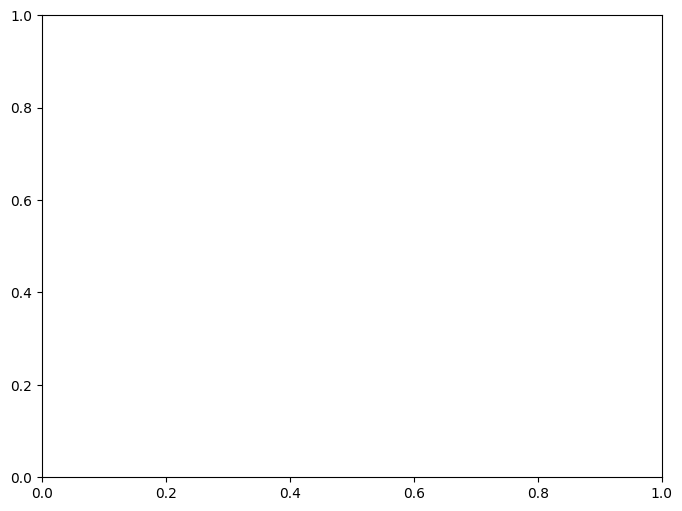

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve for I-JEPA on CIFAR-10")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epoch = 1

In [ ]:
model_state = {
       'context_encoder': context_encoder.state_dict(),
       'target_encoder': target_encoder.state_dict(),
       'predictor': predictor.state_dict(),
       'optimizer': optimizer.state_dict(),
       'epoch': epoch  # Optional: save the current epoch
   }

In [ ]:
torch.save(model_state, '/content/drive/MyDrive/SelfSupervise/i_jepa_model-2.pth')

In [ ]:
# 2. Load the saved state dictionary
model_state = torch.load('/content/drive/MyDrive/SelfSupervise/i_jepa_model-2.pth')


In [ ]:
# 3. Load the state dictionaries into your models
context_encoder.load_state_dict(model_state['context_encoder'])
target_encoder.load_state_dict(model_state['target_encoder'])
predictor.load_state_dict(model_state['predictor'])

# (Optional) If you saved the optimizer state, you can load it too:
# optimizer.load_state_dict(model_state['optimizer'])

# (Optional) If you saved the epoch, you can retrieve it:
# start_epoch = model_state['epoch'] + 1  # Resume from the next epoch

<All keys matched successfully>

In [ ]:
# Ensure the encoder is in evaluation mode.
context_encoder.eval()

all_features = []
all_labels = []

# Loop over the dataset (e.g., test_loader)
with torch.no_grad():
    for context_block, _, label in train_loader:
        # Move data to device.
        context_block = context_block.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        # Extract features (assumed shape: [B, feature_dim])
        features = context_encoder(context_block)
        # Store features and labels
        all_features.append(features.cpu())
        all_labels.append(label)

# Concatenate all features and labels from the batches.
all_features = torch.cat(all_features, dim=0).numpy()  # shape: [N, feature_dim]
all_labels = torch.cat(all_labels, dim=0).numpy()        # shape: [N]

# Dimensionality Reduction using PCA

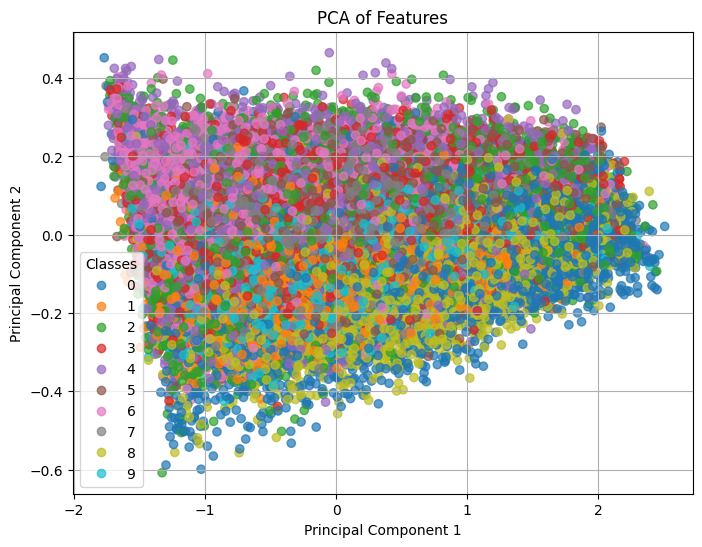

In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(all_features)

# Plot PCA results.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=all_labels, cmap="tab10", alpha=0.7)
plt.title("PCA of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()

# Dimensionality Reduction using t-SNE

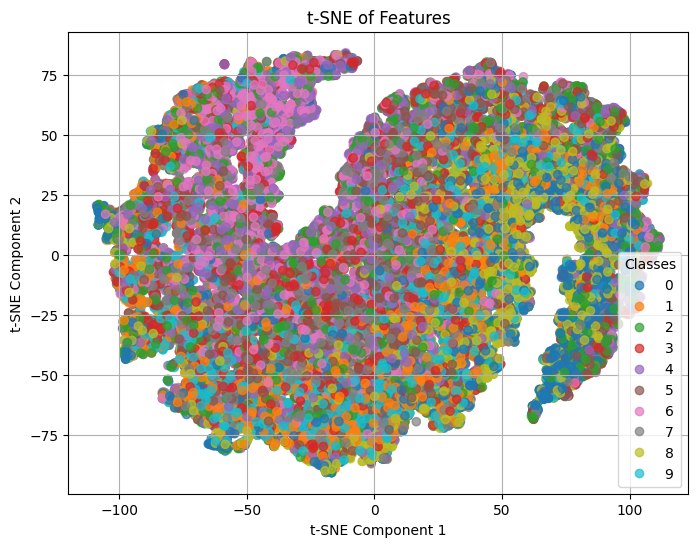

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(all_features)

# Plot t-SNE results.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=all_labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE of Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()

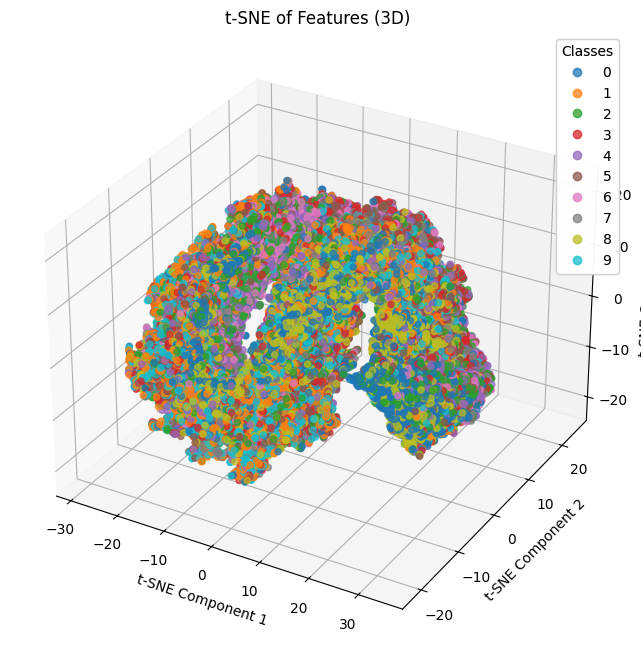

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Perform t-SNE with 3 components.
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(all_features)

# Plot t-SNE results in 3D.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2],
                     c=all_labels, cmap="tab10", alpha=0.7)

ax.set_title("t-SNE of Features (3D)")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")

# Create a legend for the classes.
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


# UMAP Dimensionality Reduction

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


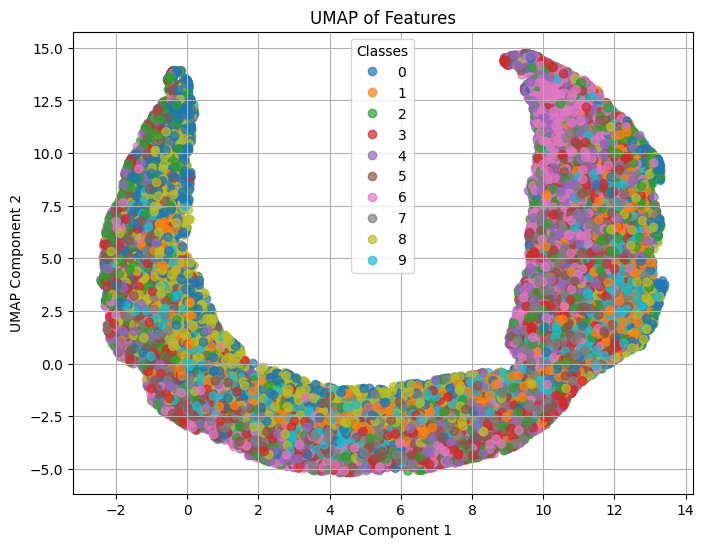

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(all_features)

# ----- Visualization -----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    features_umap[:, 0],
    features_umap[:, 1],
    c=all_labels,
    cmap="tab10",
    alpha=0.7
)
plt.title("UMAP of Features")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()

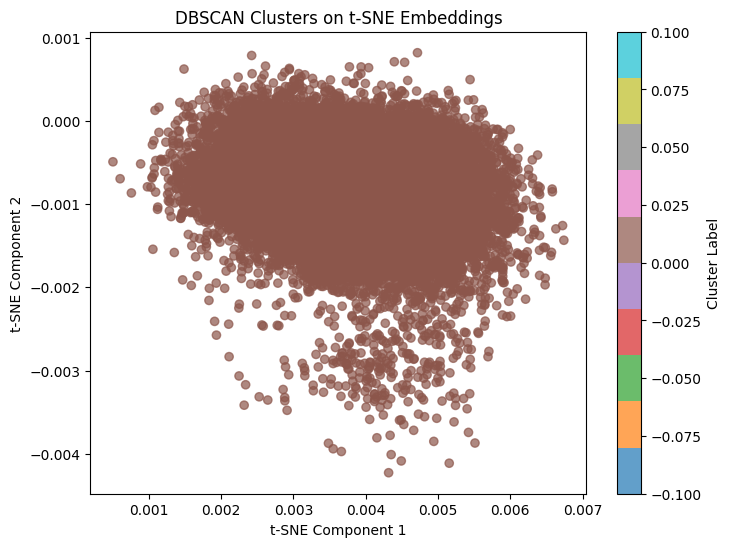

In [ ]:
from sklearn.cluster import DBSCAN
# 3. Apply DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=10)
cluster_labels = dbscan.fit_predict(all_features)

# 4. Plot Clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(all_features[:, 0], all_features[:, 1],
                      c=cluster_labels, cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clusters on t-SNE Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


Adjusted Rand Index (ARI): 0.018634829785130553


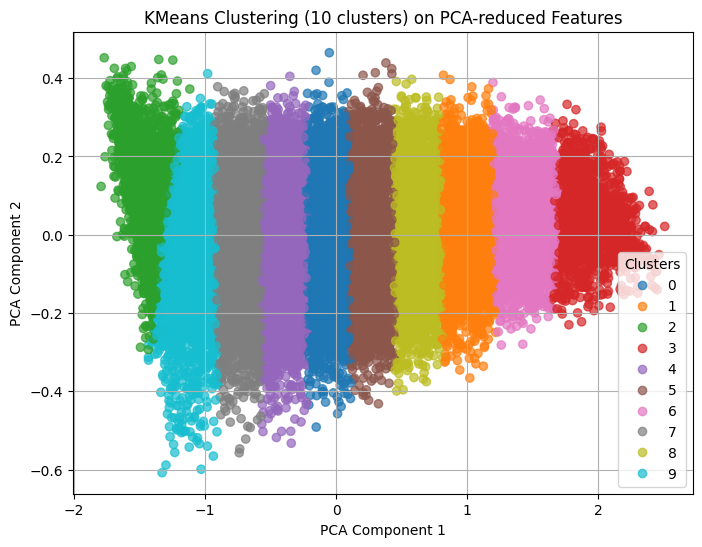

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# Convert lists to numpy arrays (if not already)
features = np.array(all_features)  # shape: (n_samples, n_features)
true_labels = np.array(all_labels) # shape: (n_samples,)

# Apply KMeans clustering with 10 clusters (for classes 0 to 9)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(features)

# Evaluate clustering performance using Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_clusters)
print("Adjusted Rand Index (ARI):", ari)

# Optional: Visualize clustering results by reducing features to 2D using PCA.
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=predicted_clusters, cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (10 clusters) on PCA-reduced Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()


# 7. Testing phase for classifier.

In [ ]:
for param in context_encoder.parameters():
    param.requires_grad = False

In [ ]:
# Define a linear classifier (mapping 768-dim features to 10 CIFAR-10 classes).
classifier = nn.Linear(768, 10).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
clf_criterion = nn.CrossEntropyLoss()

num_clf_epochs = 100
train_clf_losses = []
val_clf_losses = []

In [ ]:
import torch

# Define your model and optimizer again before loading
#classifier = ClassifierModel()  # replace with your actual model class
#clf_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)  # or your original optimizer

# Load the checkpoint
checkpoint_path = "/content/drive/MyDrive/ijepa/ijepa_classifier_epoch_lr01.pth"
checkpoint = torch.load(checkpoint_path)

# Restore state
classifier.load_state_dict(checkpoint['classifier_state_dict'])
clf_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

# Optional: restore metrics if you want to resume logging
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_accuracy = checkpoint['train_accuracy']
val_accuracy = checkpoint['val_accuracy']

print(f"Resuming from epoch {start_epoch}")


Resuming from epoch 62


# Training loop for the classifier

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

# Training loop for the classifier.
import time
from tqdm import tqdm
import torch.nn.functional as F

# Training loop for the classifier.
for epoch in range(num_clf_epochs):
    # --- Training Phase ---
    classifier.train()
    train_start = time.time()  # Start timer for training phase.

    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for context_block, _, label in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_clf_epochs}", leave=False):
        # Move data to device.
        context_block = context_block.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        label = label.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Extract features using the frozen context encoder.
        with torch.no_grad():
            features = context_encoder(context_block)
        # Compute logits and loss.
        logits = classifier(features)
        loss = clf_criterion(logits, label)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        # Accumulate loss.
        epoch_train_loss += loss.item() * context_block.size(0)
        # Count correct predictions.
        preds = logits.argmax(dim=1)
        correct_train += (preds == label).sum().item()
        total_train += label.size(0)

    train_end = time.time()  # End timer for training phase.
    train_time = train_end - train_start
    epoch_train_loss /= len(train_ijepa_dataset)
    train_accuracy = correct_train / total_train
    train_clf_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    classifier.eval()
    val_start = time.time()  # Start timer for validation phase.

    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    for context_block, _, label in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{num_clf_epochs}", leave=False):
        context_block = context_block.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        label = label.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        features = context_encoder(context_block)
        logits = classifier(features)
        loss = clf_criterion(logits, label)
        epoch_val_loss += loss.item() * context_block.size(0)

        preds = logits.argmax(dim=1)
        correct_val += (preds == label).sum().item()
        total_val += label.size(0)

    val_end = time.time()  # End timer for validation phase.
    val_time = val_end - val_start
    epoch_val_loss /= len(val_ijepa_dataset)
    val_accuracy = correct_val / total_val
    val_clf_losses.append(epoch_val_loss)

    # --- Epoch Summary ---
    print(f"Classifier Epoch {epoch+1}/{num_clf_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, "
          f"Train Time: {train_time:.2f} s, Val Time: {val_time:.2f} s")

    # --- Save Model Checkpoint ---
    checkpoint = {
        'epoch': epoch+1,
        'classifier_state_dict': classifier.state_dict(),
        'optimizer_state_dict': clf_optimizer.state_dict(),
        'train_loss': epoch_train_loss,
        'val_loss': epoch_val_loss,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
    }
    torch.save(checkpoint, f"/content/drive/MyDrive/ijepa/ijepa_classifier_epoch_lr01.pth")



Classifier Epoch 1/100, Train Loss: 22.8055, Train Acc: 23.69%, Val Loss: 15.3863, Val Acc: 26.54%, Train Time: 219.03 s, Val Time: 55.58 s


Classifier Epoch 2/100, Train Loss: 13.9192, Train Acc: 27.42%, Val Loss: 12.3764, Val Acc: 27.95%, Train Time: 223.50 s, Val Time: 55.85 s


Classifier Epoch 3/100, Train Loss: 11.7448, Train Acc: 28.76%, Val Loss: 10.9108, Val Acc: 29.89%, Train Time: 222.81 s, Val Time: 55.57 s


Classifier Epoch 4/100, Train Loss: 10.4122, Train Acc: 29.85%, Val Loss: 9.8970, Val Acc: 30.58%, Train Time: 223.11 s, Val Time: 55.90 s


Classifier Epoch 5/100, Train Loss: 9.5176, Train Acc: 30.40%, Val Loss: 9.5538, Val Acc: 30.01%, Train Time: 222.44 s, Val Time: 55.63 s


Classifier Epoch 6/100, Train Loss: 8.8861, Train Acc: 31.16%, Val Loss: 9.2924, Val Acc: 29.53%, Train Time: 222.83 s, Val Time: 55.75 s


Classifier Epoch 7/100, Train Loss: 8.3914, Train Acc: 31.74%, Val Loss: 8.2484, Val Acc: 32.86%, Train Time: 222.69 s, Val Time: 55.33 s


Classifier Epoch 8/100, Train Loss: 7.9971, Train Acc: 32.01%, Val Loss: 7.9769, Val Acc: 31.72%, Train Time: 223.67 s, Val Time: 55.31 s


Classifier Epoch 9/100, Train Loss: 7.5504, Train Acc: 32.77%, Val Loss: 7.6119, Val Acc: 32.04%, Train Time: 223.67 s, Val Time: 55.62 s


Classifier Epoch 10/100, Train Loss: 7.2868, Train Acc: 32.99%, Val Loss: 7.5446, Val Acc: 32.32%, Train Time: 224.00 s, Val Time: 55.76 s


Classifier Epoch 11/100, Train Loss: 7.0147, Train Acc: 33.33%, Val Loss: 7.2165, Val Acc: 32.89%, Train Time: 223.31 s, Val Time: 56.22 s


Classifier Epoch 12/100, Train Loss: 6.7482, Train Acc: 33.72%, Val Loss: 6.8776, Val Acc: 34.17%, Train Time: 225.26 s, Val Time: 56.02 s


Classifier Epoch 13/100, Train Loss: 6.5594, Train Acc: 34.20%, Val Loss: 7.0266, Val Acc: 32.07%, Train Time: 223.37 s, Val Time: 55.68 s


Classifier Epoch 14/100, Train Loss: 6.4170, Train Acc: 34.07%, Val Loss: 6.6852, Val Acc: 33.57%, Train Time: 223.29 s, Val Time: 55.98 s


Classifier Epoch 15/100, Train Loss: 6.1559, Train Acc: 34.55%, Val Loss: 6.7727, Val Acc: 32.08%, Train Time: 222.93 s, Val Time: 56.07 s


Classifier Epoch 16/100, Train Loss: 6.0437, Train Acc: 34.69%, Val Loss: 7.0951, Val Acc: 31.44%, Train Time: 223.56 s, Val Time: 55.61 s


Classifier Epoch 17/100, Train Loss: 5.9180, Train Acc: 34.80%, Val Loss: 5.8111, Val Acc: 35.76%, Train Time: 227.64 s, Val Time: 57.00 s


Classifier Epoch 18/100, Train Loss: 5.7494, Train Acc: 35.09%, Val Loss: 5.8252, Val Acc: 35.70%, Train Time: 227.64 s, Val Time: 56.07 s


Classifier Epoch 19/100, Train Loss: 5.6588, Train Acc: 35.25%, Val Loss: 5.5208, Val Acc: 36.03%, Train Time: 223.94 s, Val Time: 56.31 s


Classifier Epoch 20/100, Train Loss: 5.4886, Train Acc: 35.65%, Val Loss: 5.9961, Val Acc: 33.94%, Train Time: 223.49 s, Val Time: 56.05 s


Classifier Epoch 21/100, Train Loss: 5.4084, Train Acc: 35.83%, Val Loss: 5.7584, Val Acc: 35.38%, Train Time: 222.72 s, Val Time: 55.88 s


Classifier Epoch 22/100, Train Loss: 5.2755, Train Acc: 35.94%, Val Loss: 5.3939, Val Acc: 36.53%, Train Time: 223.73 s, Val Time: 56.02 s


Classifier Epoch 23/100, Train Loss: 5.2236, Train Acc: 35.82%, Val Loss: 5.5669, Val Acc: 35.22%, Train Time: 223.53 s, Val Time: 56.09 s


Classifier Epoch 24/100, Train Loss: 5.0955, Train Acc: 35.86%, Val Loss: 5.3318, Val Acc: 35.68%, Train Time: 223.33 s, Val Time: 56.13 s


Classifier Epoch 25/100, Train Loss: 5.0249, Train Acc: 36.68%, Val Loss: 5.4068, Val Acc: 35.23%, Train Time: 223.45 s, Val Time: 55.79 s


Classifier Epoch 26/100, Train Loss: 4.9351, Train Acc: 36.45%, Val Loss: 5.3290, Val Acc: 34.94%, Train Time: 223.84 s, Val Time: 55.85 s


Classifier Epoch 27/100, Train Loss: 4.8600, Train Acc: 36.59%, Val Loss: 4.9728, Val Acc: 34.97%, Train Time: 223.66 s, Val Time: 55.46 s


Classifier Epoch 28/100, Train Loss: 4.7821, Train Acc: 36.54%, Val Loss: 5.2477, Val Acc: 34.51%, Train Time: 223.30 s, Val Time: 55.77 s


Classifier Epoch 29/100, Train Loss: 4.7254, Train Acc: 36.77%, Val Loss: 5.0132, Val Acc: 36.76%, Train Time: 223.72 s, Val Time: 55.97 s


Classifier Epoch 30/100, Train Loss: 4.6776, Train Acc: 37.00%, Val Loss: 5.4014, Val Acc: 35.93%, Train Time: 224.45 s, Val Time: 56.17 s


Classifier Epoch 31/100, Train Loss: 4.5959, Train Acc: 37.06%, Val Loss: 4.7520, Val Acc: 37.40%, Train Time: 223.69 s, Val Time: 55.84 s


Classifier Epoch 32/100, Train Loss: 4.5369, Train Acc: 37.17%, Val Loss: 4.8472, Val Acc: 37.04%, Train Time: 223.69 s, Val Time: 56.05 s


Classifier Epoch 33/100, Train Loss: 4.4877, Train Acc: 37.23%, Val Loss: 4.8225, Val Acc: 36.53%, Train Time: 223.94 s, Val Time: 56.16 s


Classifier Epoch 34/100, Train Loss: 4.4017, Train Acc: 37.49%, Val Loss: 4.5121, Val Acc: 37.33%, Train Time: 223.83 s, Val Time: 55.84 s


Classifier Epoch 35/100, Train Loss: 4.3738, Train Acc: 37.60%, Val Loss: 4.8548, Val Acc: 36.19%, Train Time: 224.37 s, Val Time: 56.05 s


Classifier Epoch 36/100, Train Loss: 4.3362, Train Acc: 37.63%, Val Loss: 5.1203, Val Acc: 35.44%, Train Time: 224.83 s, Val Time: 56.11 s


Classifier Epoch 37/100, Train Loss: 4.2687, Train Acc: 37.64%, Val Loss: 4.3749, Val Acc: 38.97%, Train Time: 224.89 s, Val Time: 55.91 s


Classifier Epoch 38/100, Train Loss: 4.2365, Train Acc: 37.66%, Val Loss: 4.3075, Val Acc: 38.65%, Train Time: 224.67 s, Val Time: 56.06 s


Classifier Epoch 39/100, Train Loss: 4.1943, Train Acc: 37.88%, Val Loss: 4.3508, Val Acc: 38.92%, Train Time: 225.27 s, Val Time: 55.90 s


Classifier Epoch 40/100, Train Loss: 4.1331, Train Acc: 37.92%, Val Loss: 4.5763, Val Acc: 35.93%, Train Time: 224.97 s, Val Time: 56.53 s


Classifier Epoch 41/100, Train Loss: 4.1535, Train Acc: 37.71%, Val Loss: 4.5887, Val Acc: 37.11%, Train Time: 224.84 s, Val Time: 55.97 s


Classifier Epoch 42/100, Train Loss: 4.0661, Train Acc: 38.15%, Val Loss: 4.4639, Val Acc: 37.11%, Train Time: 225.27 s, Val Time: 56.43 s


Classifier Epoch 43/100, Train Loss: 4.0001, Train Acc: 38.20%, Val Loss: 4.3083, Val Acc: 38.21%, Train Time: 223.87 s, Val Time: 56.34 s


Classifier Epoch 44/100, Train Loss: 4.0120, Train Acc: 38.32%, Val Loss: 4.4088, Val Acc: 36.90%, Train Time: 224.97 s, Val Time: 56.53 s


Classifier Epoch 45/100, Train Loss: 3.9590, Train Acc: 38.34%, Val Loss: 4.1651, Val Acc: 38.92%, Train Time: 224.72 s, Val Time: 56.33 s


Classifier Epoch 46/100, Train Loss: 3.9155, Train Acc: 38.45%, Val Loss: 4.2157, Val Acc: 38.22%, Train Time: 225.20 s, Val Time: 56.12 s


Classifier Epoch 47/100, Train Loss: 3.8873, Train Acc: 38.48%, Val Loss: 4.2036, Val Acc: 38.26%, Train Time: 224.27 s, Val Time: 56.19 s


Classifier Epoch 48/100, Train Loss: 3.8778, Train Acc: 38.57%, Val Loss: 4.4751, Val Acc: 36.23%, Train Time: 225.98 s, Val Time: 56.62 s


Classifier Epoch 49/100, Train Loss: 3.8264, Train Acc: 38.63%, Val Loss: 4.1066, Val Acc: 37.31%, Train Time: 226.33 s, Val Time: 56.32 s


Classifier Epoch 50/100, Train Loss: 3.8073, Train Acc: 38.69%, Val Loss: 4.0405, Val Acc: 38.63%, Train Time: 224.98 s, Val Time: 56.33 s


Classifier Epoch 51/100, Train Loss: 3.7594, Train Acc: 38.73%, Val Loss: 3.9846, Val Acc: 38.20%, Train Time: 224.97 s, Val Time: 56.15 s


Classifier Epoch 52/100, Train Loss: 3.7458, Train Acc: 38.80%, Val Loss: 3.7982, Val Acc: 39.39%, Train Time: 226.02 s, Val Time: 56.10 s


Classifier Epoch 53/100, Train Loss: 3.7190, Train Acc: 39.03%, Val Loss: 3.9736, Val Acc: 38.48%, Train Time: 225.00 s, Val Time: 56.75 s


Classifier Epoch 54/100, Train Loss: 3.6845, Train Acc: 39.10%, Val Loss: 4.1574, Val Acc: 36.41%, Train Time: 225.58 s, Val Time: 56.04 s


Classifier Epoch 55/100, Train Loss: 3.6899, Train Acc: 38.94%, Val Loss: 4.0179, Val Acc: 38.70%, Train Time: 226.01 s, Val Time: 56.01 s


Classifier Epoch 56/100, Train Loss: 3.6476, Train Acc: 39.09%, Val Loss: 4.5675, Val Acc: 35.45%, Train Time: 224.68 s, Val Time: 56.36 s


Classifier Epoch 57/100, Train Loss: 3.6730, Train Acc: 39.00%, Val Loss: 4.1758, Val Acc: 35.95%, Train Time: 223.94 s, Val Time: 56.27 s


Classifier Epoch 58/100, Train Loss: 3.6467, Train Acc: 38.90%, Val Loss: 3.8938, Val Acc: 37.60%, Train Time: 224.90 s, Val Time: 56.01 s


Classifier Epoch 59/100, Train Loss: 3.5696, Train Acc: 39.48%, Val Loss: 3.6826, Val Acc: 39.06%, Train Time: 224.46 s, Val Time: 56.40 s


Classifier Epoch 60/100, Train Loss: 3.5687, Train Acc: 39.26%, Val Loss: 3.8976, Val Acc: 39.49%, Train Time: 224.62 s, Val Time: 56.29 s


Classifier Epoch 61/100, Train Loss: 3.5626, Train Acc: 39.43%, Val Loss: 4.0490, Val Acc: 38.84%, Train Time: 224.36 s, Val Time: 56.10 s


Classifier Epoch 62/100, Train Loss: 3.4951, Train Acc: 39.57%, Val Loss: 3.9401, Val Acc: 40.47%, Train Time: 223.90 s, Val Time: 56.09 s


Classifier Epoch 63/100, Train Loss: 3.5170, Train Acc: 39.38%, Val Loss: 3.7171, Val Acc: 39.42%, Train Time: 225.19 s, Val Time: 56.15 s


Classifier Epoch 64/100, Train Loss: 3.4822, Train Acc: 39.41%, Val Loss: 3.6587, Val Acc: 38.90%, Train Time: 224.00 s, Val Time: 56.50 s


Classifier Epoch 65/100, Train Loss: 3.4330, Train Acc: 39.88%, Val Loss: 3.7057, Val Acc: 40.05%, Train Time: 224.78 s, Val Time: 56.15 s


Classifier Epoch 66/100, Train Loss: 3.4470, Train Acc: 39.45%, Val Loss: 3.7792, Val Acc: 37.16%, Train Time: 224.64 s, Val Time: 56.07 s


Classifier Epoch 67/100, Train Loss: 3.4131, Train Acc: 39.90%, Val Loss: 4.0644, Val Acc: 36.62%, Train Time: 223.97 s, Val Time: 56.30 s


Classifier Epoch 68/100, Train Loss: 3.4518, Train Acc: 39.38%, Val Loss: 3.5287, Val Acc: 39.82%, Train Time: 225.00 s, Val Time: 55.99 s


Classifier Epoch 69/100, Train Loss: 3.4137, Train Acc: 39.46%, Val Loss: 3.7452, Val Acc: 38.29%, Train Time: 223.98 s, Val Time: 55.84 s


Classifier Epoch 70/100, Train Loss: 3.2993, Train Acc: 40.21%, Val Loss: 3.6738, Val Acc: 39.57%, Train Time: 224.91 s, Val Time: 56.16 s


Classifier Epoch 71/100, Train Loss: 3.3585, Train Acc: 40.18%, Val Loss: 3.4949, Val Acc: 39.05%, Train Time: 224.63 s, Val Time: 56.03 s


Classifier Epoch 72/100, Train Loss: 3.3405, Train Acc: 40.23%, Val Loss: 3.4368, Val Acc: 39.51%, Train Time: 224.26 s, Val Time: 56.32 s


Classifier Epoch 73/100, Train Loss: 3.3046, Train Acc: 40.10%, Val Loss: 3.7785, Val Acc: 37.48%, Train Time: 224.85 s, Val Time: 56.17 s


Classifier Epoch 74/100, Train Loss: 3.2987, Train Acc: 40.30%, Val Loss: 3.9910, Val Acc: 37.45%, Train Time: 224.42 s, Val Time: 56.37 s


Classifier Epoch 75/100, Train Loss: 3.2649, Train Acc: 40.37%, Val Loss: 3.6193, Val Acc: 37.80%, Train Time: 224.96 s, Val Time: 56.19 s


Classifier Epoch 76/100, Train Loss: 3.3006, Train Acc: 40.01%, Val Loss: 3.8382, Val Acc: 36.56%, Train Time: 224.49 s, Val Time: 55.89 s


Classifier Epoch 77/100, Train Loss: 3.2335, Train Acc: 40.29%, Val Loss: 3.5978, Val Acc: 37.31%, Train Time: 225.30 s, Val Time: 56.49 s


Classifier Epoch 78/100, Train Loss: 3.2503, Train Acc: 40.38%, Val Loss: 3.7644, Val Acc: 39.28%, Train Time: 224.00 s, Val Time: 55.89 s


Classifier Epoch 79/100, Train Loss: 3.2348, Train Acc: 40.27%, Val Loss: 3.6250, Val Acc: 38.14%, Train Time: 224.64 s, Val Time: 55.83 s


Classifier Epoch 80/100, Train Loss: 3.1838, Train Acc: 40.17%, Val Loss: 3.6055, Val Acc: 39.80%, Train Time: 224.99 s, Val Time: 56.06 s


Classifier Epoch 81/100, Train Loss: 3.1994, Train Acc: 40.23%, Val Loss: 3.3141, Val Acc: 40.23%, Train Time: 224.98 s, Val Time: 56.14 s


Classifier Epoch 82/100, Train Loss: 3.1892, Train Acc: 40.31%, Val Loss: 3.3023, Val Acc: 40.09%, Train Time: 223.70 s, Val Time: 56.24 s


Classifier Epoch 83/100, Train Loss: 3.1579, Train Acc: 40.64%, Val Loss: 3.7988, Val Acc: 36.68%, Train Time: 225.10 s, Val Time: 55.81 s


Classifier Epoch 84/100, Train Loss: 3.1451, Train Acc: 40.55%, Val Loss: 3.4782, Val Acc: 38.09%, Train Time: 225.15 s, Val Time: 56.01 s


Classifier Epoch 85/100, Train Loss: 3.1517, Train Acc: 40.44%, Val Loss: 3.3545, Val Acc: 39.45%, Train Time: 223.98 s, Val Time: 55.81 s


Classifier Epoch 86/100, Train Loss: 3.1436, Train Acc: 40.16%, Val Loss: 3.3656, Val Acc: 39.53%, Train Time: 224.42 s, Val Time: 56.28 s


Classifier Epoch 87/100, Train Loss: 3.1198, Train Acc: 40.41%, Val Loss: 3.1459, Val Acc: 41.00%, Train Time: 224.19 s, Val Time: 56.21 s


Classifier Epoch 88/100, Train Loss: 3.0963, Train Acc: 40.43%, Val Loss: 3.5618, Val Acc: 37.99%, Train Time: 224.60 s, Val Time: 56.27 s


Classifier Epoch 89/100, Train Loss: 3.1088, Train Acc: 40.26%, Val Loss: 3.4669, Val Acc: 38.63%, Train Time: 224.24 s, Val Time: 55.95 s


Classifier Epoch 90/100, Train Loss: 3.0676, Train Acc: 40.89%, Val Loss: 3.4963, Val Acc: 39.61%, Train Time: 223.92 s, Val Time: 56.21 s


Classifier Epoch 91/100, Train Loss: 3.1115, Train Acc: 40.46%, Val Loss: 3.7381, Val Acc: 38.49%, Train Time: 224.61 s, Val Time: 55.80 s


Classifier Epoch 92/100, Train Loss: 3.0776, Train Acc: 40.86%, Val Loss: 3.2874, Val Acc: 39.02%, Train Time: 223.98 s, Val Time: 56.44 s


Classifier Epoch 93/100, Train Loss: 3.0755, Train Acc: 40.80%, Val Loss: 3.4312, Val Acc: 38.13%, Train Time: 224.53 s, Val Time: 55.92 s


Classifier Epoch 94/100, Train Loss: 3.0430, Train Acc: 40.54%, Val Loss: 3.3939, Val Acc: 39.34%, Train Time: 224.03 s, Val Time: 55.91 s


Classifier Epoch 95/100, Train Loss: 3.0219, Train Acc: 40.71%, Val Loss: 3.4724, Val Acc: 37.33%, Train Time: 224.19 s, Val Time: 56.29 s


Classifier Epoch 96/100, Train Loss: 3.0276, Train Acc: 40.66%, Val Loss: 3.0647, Val Acc: 42.59%, Train Time: 225.52 s, Val Time: 55.92 s


Classifier Epoch 97/100, Train Loss: 3.0787, Train Acc: 40.62%, Val Loss: 3.4588, Val Acc: 37.68%, Train Time: 224.02 s, Val Time: 56.28 s


Classifier Epoch 98/100, Train Loss: 3.0052, Train Acc: 41.07%, Val Loss: 3.1455, Val Acc: 41.48%, Train Time: 225.68 s, Val Time: 55.99 s


Classifier Epoch 99/100, Train Loss: 3.0086, Train Acc: 40.73%, Val Loss: 3.4539, Val Acc: 37.86%, Train Time: 225.28 s, Val Time: 56.04 s


Classifier Epoch 100/100, Train Loss: 3.0166, Train Acc: 40.49%, Val Loss: 3.2910, Val Acc: 38.62%, Train Time: 224.58 s, Val Time: 56.34 s


# Grid Search for learning rate

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Global directory for saving models and images.
SAVE_DIR = "/content/drive/MyDrive/ijepa/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Assume the following variables are already defined:
# - train_loader, val_loader: your data loaders.
# - context_encoder: your frozen encoder.
# - num_clf_epochs: number of epochs to train the classifier.
# - train_ijepa_dataset, val_ijepa_dataset: datasets (used for loss normalization).

# List of candidate learning rates for grid search.
candidate_lrs = [1e-4, 1e-3, 1e-2]
num_clf_epochs = 50
# To store overall results for each learning rate.
grid_search_results = {}
learning_curves = {}  # This will hold loss and accuracy curves for each candidate LR.
model_checkpoints = {}  # To store best model checkpoints for each candidate LR.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop over candidate learning rates.
for lr in candidate_lrs:
    print(f"\n=== Training with learning rate: {lr} ===")
    # Initialize a new classifier and optimizer for each candidate.
    classifier = nn.Linear(768, 10).to(device)
    clf_optimizer = optim.Adam(classifier.parameters(), lr=lr)
    clf_criterion = nn.CrossEntropyLoss()

    # Lists to track per-epoch metrics.
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_accuracy = 0.0
    best_checkpoint = None  # Will store the best model state for this LR.

    for epoch in range(num_clf_epochs):
        # --- Training Phase ---
        classifier.train()
        train_start = time.time()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for context_block, _, label in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_clf_epochs}", leave=False):
            context_block = context_block.to(device)
            label = label.to(device)

            # Extract features using the frozen context encoder.
            with torch.no_grad():
                features = context_encoder(context_block)
            logits = classifier(features)
            loss = clf_criterion(logits, label)

            clf_optimizer.zero_grad()
            loss.backward()
            clf_optimizer.step()

            epoch_train_loss += loss.item() * context_block.size(0)
            preds = logits.argmax(dim=1)
            correct_train += (preds == label).sum().item()
            total_train += label.size(0)

        epoch_train_loss /= len(train_ijepa_dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accs.append(train_accuracy)
        train_time = time.time() - train_start

        # --- Validation Phase ---
        classifier.eval()
        val_start = time.time()
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0

        for context_block, _, label in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{num_clf_epochs}", leave=False):
            context_block = context_block.to(device)
            label = label.to(device)
            with torch.no_grad():
                features = context_encoder(context_block)
                logits = classifier(features)
                loss = clf_criterion(logits, label)
            epoch_val_loss += loss.item() * context_block.size(0)
            preds = logits.argmax(dim=1)
            correct_val += (preds == label).sum().item()
            total_val += label.size(0)

        epoch_val_loss /= len(val_ijepa_dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(val_accuracy)
        val_time = time.time() - val_start

        print(f"Epoch {epoch+1}/{num_clf_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {train_accuracy*100:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}% | "
              f"Train Time: {train_time:.2f} s, Val Time: {val_time:.2f} s")

        # Save checkpoint if validation accuracy improves.
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_checkpoint = {
                'epoch': epoch+1,
                'classifier_state_dict': classifier.state_dict(),
                'optimizer_state_dict': clf_optimizer.state_dict(),
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
            }

    grid_search_results[lr] = best_val_accuracy
    learning_curves[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    model_checkpoints[lr] = best_checkpoint

    # Save the best model checkpoint for this learning rate.
    checkpoint_path = os.path.join(SAVE_DIR, f"model_lr_{lr}.pth")
    torch.save(best_checkpoint, checkpoint_path)
    print(f"Saved best model checkpoint for lr={lr} at {checkpoint_path}")
    print(f"Learning rate {lr} achieved best validation accuracy: {best_val_accuracy*100:.2f}%")

    # --- Generate and Save Learning Curves ---
    epochs = np.arange(1, num_clf_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot.
    axs[0].plot(epochs, train_losses, label='Train Loss')
    axs[0].plot(epochs, val_losses, label='Val Loss')
    axs[0].set_title(f"Loss Curve (lr={lr})")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Accuracy plot.
    axs[1].plot(epochs, [acc * 100 for acc in train_accs], label='Train Accuracy')
    axs[1].plot(epochs, [acc * 100 for acc in val_accs], label='Val Accuracy')
    axs[1].set_title(f"Accuracy Curve (lr={lr})")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    curve_path = os.path.join(SAVE_DIR, f"learning_curve_lr_{lr}.png")
    plt.savefig(curve_path)
    plt.close(fig)
    print(f"Saved learning curve plot for lr={lr} at {curve_path}")

# --- Overall Grid Search Results ---
print("\n=== Grid Search Results ===")
for lr, val_acc in grid_search_results.items():
    print(f"LR: {lr} -> Best Val Accuracy: {val_acc*100:.2f}%")

best_lr = max(grid_search_results, key=grid_search_results.get)
print(f"\nBest learning rate: {best_lr} with validation accuracy: {grid_search_results[best_lr]*100:.2f}%")



=== Training with learning rate: 0.0001 ===


Epoch 1/50 | Train Loss: 2.2722 | Train Acc: 17.34% | Val Loss: 2.2471 | Val Acc: 18.34% | Train Time: 205.25 s, Val Time: 51.55 s


Epoch 2/50 | Train Loss: 2.2277 | Train Acc: 19.43% | Val Loss: 2.2111 | Val Acc: 19.76% | Train Time: 204.82 s, Val Time: 51.15 s


Epoch 3/50 | Train Loss: 2.1975 | Train Acc: 20.37% | Val Loss: 2.1856 | Val Acc: 21.10% | Train Time: 205.15 s, Val Time: 51.17 s


Epoch 4/50 | Train Loss: 2.1754 | Train Acc: 21.47% | Val Loss: 2.1659 | Val Acc: 22.01% | Train Time: 205.26 s, Val Time: 51.36 s


Epoch 5/50 | Train Loss: 2.1580 | Train Acc: 22.20% | Val Loss: 2.1498 | Val Acc: 22.47% | Train Time: 205.22 s, Val Time: 51.31 s


Epoch 6/50 | Train Loss: 2.1435 | Train Acc: 22.78% | Val Loss: 2.1359 | Val Acc: 22.97% | Train Time: 204.95 s, Val Time: 51.23 s


Epoch 7/50 | Train Loss: 2.1309 | Train Acc: 23.10% | Val Loss: 2.1237 | Val Acc: 23.40% | Train Time: 205.06 s, Val Time: 51.13 s


Epoch 8/50 | Train Loss: 2.1196 | Train Acc: 23.54% | Val Loss: 2.1127 | Val Acc: 23.78% | Train Time: 204.20 s, Val Time: 51.35 s


Epoch 9/50 | Train Loss: 2.1095 | Train Acc: 23.80% | Val Loss: 2.1028 | Val Acc: 24.26% | Train Time: 204.81 s, Val Time: 51.10 s


Epoch 10/50 | Train Loss: 2.1003 | Train Acc: 24.20% | Val Loss: 2.0937 | Val Acc: 24.43% | Train Time: 204.52 s, Val Time: 51.01 s


Epoch 11/50 | Train Loss: 2.0919 | Train Acc: 24.51% | Val Loss: 2.0854 | Val Acc: 24.72% | Train Time: 204.89 s, Val Time: 51.48 s


Epoch 12/50 | Train Loss: 2.0842 | Train Acc: 24.77% | Val Loss: 2.0777 | Val Acc: 24.97% | Train Time: 204.75 s, Val Time: 51.20 s


Epoch 13/50 | Train Loss: 2.0770 | Train Acc: 25.05% | Val Loss: 2.0705 | Val Acc: 25.27% | Train Time: 204.58 s, Val Time: 51.40 s


Epoch 14/50 | Train Loss: 2.0704 | Train Acc: 25.25% | Val Loss: 2.0640 | Val Acc: 25.46% | Train Time: 204.10 s, Val Time: 51.25 s


Epoch 15/50 | Train Loss: 2.0643 | Train Acc: 25.46% | Val Loss: 2.0579 | Val Acc: 25.60% | Train Time: 204.89 s, Val Time: 50.88 s


Epoch 16/50 | Train Loss: 2.0586 | Train Acc: 25.54% | Val Loss: 2.0523 | Val Acc: 25.76% | Train Time: 203.90 s, Val Time: 50.90 s


Epoch 17/50 | Train Loss: 2.0533 | Train Acc: 25.69% | Val Loss: 2.0470 | Val Acc: 25.92% | Train Time: 205.14 s, Val Time: 51.29 s


Epoch 18/50 | Train Loss: 2.0484 | Train Acc: 25.84% | Val Loss: 2.0421 | Val Acc: 26.26% | Train Time: 205.36 s, Val Time: 50.86 s


Epoch 19/50 | Train Loss: 2.0438 | Train Acc: 25.88% | Val Loss: 2.0375 | Val Acc: 26.32% | Train Time: 204.76 s, Val Time: 51.66 s


Epoch 20/50 | Train Loss: 2.0396 | Train Acc: 26.01% | Val Loss: 2.0332 | Val Acc: 26.47% | Train Time: 206.47 s, Val Time: 51.70 s


Epoch 21/50 | Train Loss: 2.0356 | Train Acc: 26.12% | Val Loss: 2.0293 | Val Acc: 26.74% | Train Time: 205.96 s, Val Time: 51.67 s


Epoch 22/50 | Train Loss: 2.0319 | Train Acc: 26.24% | Val Loss: 2.0255 | Val Acc: 26.74% | Train Time: 206.31 s, Val Time: 51.51 s


Epoch 23/50 | Train Loss: 2.0284 | Train Acc: 26.29% | Val Loss: 2.0220 | Val Acc: 26.99% | Train Time: 206.29 s, Val Time: 51.82 s


Epoch 24/50 | Train Loss: 2.0251 | Train Acc: 26.55% | Val Loss: 2.0188 | Val Acc: 26.90% | Train Time: 205.52 s, Val Time: 51.48 s


Epoch 25/50 | Train Loss: 2.0220 | Train Acc: 26.55% | Val Loss: 2.0157 | Val Acc: 27.01% | Train Time: 206.11 s, Val Time: 51.65 s


Epoch 26/50 | Train Loss: 2.0191 | Train Acc: 26.61% | Val Loss: 2.0128 | Val Acc: 27.25% | Train Time: 206.00 s, Val Time: 51.82 s


Epoch 27/50 | Train Loss: 2.0164 | Train Acc: 26.73% | Val Loss: 2.0100 | Val Acc: 27.30% | Train Time: 205.86 s, Val Time: 51.67 s


Epoch 28/50 | Train Loss: 2.0138 | Train Acc: 26.79% | Val Loss: 2.0074 | Val Acc: 27.33% | Train Time: 205.75 s, Val Time: 51.65 s


Epoch 29/50 | Train Loss: 2.0113 | Train Acc: 26.96% | Val Loss: 2.0048 | Val Acc: 27.38% | Train Time: 206.42 s, Val Time: 51.67 s


Epoch 30/50 | Train Loss: 2.0090 | Train Acc: 26.94% | Val Loss: 2.0025 | Val Acc: 27.35% | Train Time: 206.50 s, Val Time: 51.44 s


Epoch 31/50 | Train Loss: 2.0068 | Train Acc: 26.92% | Val Loss: 2.0002 | Val Acc: 27.54% | Train Time: 205.35 s, Val Time: 50.94 s


Epoch 32/50 | Train Loss: 2.0048 | Train Acc: 27.08% | Val Loss: 1.9982 | Val Acc: 27.55% | Train Time: 204.87 s, Val Time: 51.53 s


Epoch 33/50 | Train Loss: 2.0028 | Train Acc: 27.12% | Val Loss: 1.9961 | Val Acc: 27.49% | Train Time: 205.99 s, Val Time: 51.14 s


Epoch 34/50 | Train Loss: 2.0009 | Train Acc: 27.19% | Val Loss: 1.9943 | Val Acc: 27.65% | Train Time: 204.93 s, Val Time: 51.10 s


Epoch 35/50 | Train Loss: 1.9991 | Train Acc: 27.18% | Val Loss: 1.9924 | Val Acc: 27.64% | Train Time: 205.11 s, Val Time: 51.11 s


Epoch 36/50 | Train Loss: 1.9974 | Train Acc: 27.24% | Val Loss: 1.9906 | Val Acc: 27.77% | Train Time: 203.93 s, Val Time: 51.42 s


Epoch 37/50 | Train Loss: 1.9957 | Train Acc: 27.32% | Val Loss: 1.9890 | Val Acc: 27.87% | Train Time: 205.39 s, Val Time: 51.16 s


Epoch 38/50 | Train Loss: 1.9942 | Train Acc: 27.32% | Val Loss: 1.9874 | Val Acc: 27.79% | Train Time: 205.49 s, Val Time: 50.69 s


Epoch 39/50 | Train Loss: 1.9927 | Train Acc: 27.40% | Val Loss: 1.9859 | Val Acc: 27.83% | Train Time: 205.24 s, Val Time: 51.03 s


Epoch 40/50 | Train Loss: 1.9912 | Train Acc: 27.53% | Val Loss: 1.9844 | Val Acc: 27.92% | Train Time: 204.84 s, Val Time: 51.14 s


Epoch 41/50 | Train Loss: 1.9898 | Train Acc: 27.58% | Val Loss: 1.9830 | Val Acc: 27.99% | Train Time: 204.85 s, Val Time: 51.40 s


Epoch 42/50 | Train Loss: 1.9885 | Train Acc: 27.55% | Val Loss: 1.9816 | Val Acc: 27.97% | Train Time: 205.33 s, Val Time: 51.14 s


Epoch 43/50 | Train Loss: 1.9872 | Train Acc: 27.65% | Val Loss: 1.9803 | Val Acc: 27.97% | Train Time: 204.78 s, Val Time: 51.51 s


Epoch 44/50 | Train Loss: 1.9860 | Train Acc: 27.72% | Val Loss: 1.9790 | Val Acc: 28.01% | Train Time: 204.59 s, Val Time: 51.35 s


Epoch 45/50 | Train Loss: 1.9848 | Train Acc: 27.66% | Val Loss: 1.9778 | Val Acc: 28.00% | Train Time: 204.46 s, Val Time: 51.18 s


Epoch 46/50 | Train Loss: 1.9836 | Train Acc: 27.77% | Val Loss: 1.9766 | Val Acc: 28.00% | Train Time: 205.33 s, Val Time: 51.10 s


Epoch 47/50 | Train Loss: 1.9825 | Train Acc: 27.82% | Val Loss: 1.9755 | Val Acc: 27.97% | Train Time: 204.73 s, Val Time: 51.20 s


Epoch 48/50 | Train Loss: 1.9815 | Train Acc: 27.88% | Val Loss: 1.9744 | Val Acc: 28.05% | Train Time: 205.79 s, Val Time: 51.51 s


Epoch 49/50 | Train Loss: 1.9804 | Train Acc: 27.94% | Val Loss: 1.9732 | Val Acc: 28.04% | Train Time: 206.75 s, Val Time: 51.67 s


Epoch 50/50 | Train Loss: 1.9794 | Train Acc: 27.96% | Val Loss: 1.9722 | Val Acc: 28.07% | Train Time: 206.37 s, Val Time: 51.50 s
Saved best model checkpoint for lr=0.0001 at /content/drive/MyDrive/ijepa/model_lr_0.0001.pth
Learning rate 0.0001 achieved best validation accuracy: 28.07%
Saved learning curve plot for lr=0.0001 at /content/drive/MyDrive/ijepa/learning_curve_lr_0.0001.png

=== Training with learning rate: 0.001 ===


Epoch 1/50 | Train Loss: 2.1641 | Train Acc: 22.05% | Val Loss: 2.0966 | Val Acc: 24.07% | Train Time: 206.54 s, Val Time: 51.35 s


Epoch 2/50 | Train Loss: 2.0663 | Train Acc: 25.02% | Val Loss: 2.0361 | Val Acc: 26.06% | Train Time: 205.51 s, Val Time: 51.30 s


Epoch 3/50 | Train Loss: 2.0242 | Train Acc: 26.25% | Val Loss: 2.0044 | Val Acc: 27.29% | Train Time: 204.89 s, Val Time: 51.05 s


Epoch 4/50 | Train Loss: 2.0008 | Train Acc: 27.10% | Val Loss: 1.9858 | Val Acc: 27.99% | Train Time: 205.06 s, Val Time: 51.32 s


Epoch 5/50 | Train Loss: 1.9863 | Train Acc: 27.53% | Val Loss: 1.9731 | Val Acc: 27.99% | Train Time: 204.72 s, Val Time: 51.27 s


Epoch 6/50 | Train Loss: 1.9763 | Train Acc: 27.88% | Val Loss: 1.9641 | Val Acc: 28.37% | Train Time: 204.40 s, Val Time: 51.11 s


Epoch 7/50 | Train Loss: 1.9687 | Train Acc: 28.19% | Val Loss: 1.9576 | Val Acc: 28.57% | Train Time: 205.47 s, Val Time: 51.01 s


Epoch 8/50 | Train Loss: 1.9627 | Train Acc: 28.48% | Val Loss: 1.9518 | Val Acc: 28.80% | Train Time: 205.56 s, Val Time: 51.13 s


Epoch 9/50 | Train Loss: 1.9578 | Train Acc: 28.67% | Val Loss: 1.9469 | Val Acc: 28.81% | Train Time: 205.36 s, Val Time: 51.33 s


Epoch 10/50 | Train Loss: 1.9536 | Train Acc: 28.72% | Val Loss: 1.9429 | Val Acc: 29.00% | Train Time: 204.78 s, Val Time: 51.33 s


Epoch 11/50 | Train Loss: 1.9499 | Train Acc: 28.92% | Val Loss: 1.9393 | Val Acc: 29.20% | Train Time: 204.25 s, Val Time: 51.19 s


Epoch 12/50 | Train Loss: 1.9468 | Train Acc: 29.00% | Val Loss: 1.9369 | Val Acc: 29.29% | Train Time: 205.76 s, Val Time: 51.26 s


Epoch 13/50 | Train Loss: 1.9441 | Train Acc: 29.22% | Val Loss: 1.9337 | Val Acc: 29.60% | Train Time: 205.39 s, Val Time: 51.03 s


Epoch 14/50 | Train Loss: 1.9415 | Train Acc: 29.31% | Val Loss: 1.9309 | Val Acc: 29.43% | Train Time: 205.03 s, Val Time: 51.63 s


Epoch 15/50 | Train Loss: 1.9390 | Train Acc: 29.31% | Val Loss: 1.9284 | Val Acc: 29.66% | Train Time: 204.82 s, Val Time: 51.51 s


Epoch 16/50 | Train Loss: 1.9371 | Train Acc: 29.53% | Val Loss: 1.9263 | Val Acc: 29.83% | Train Time: 205.31 s, Val Time: 50.97 s


Epoch 17/50 | Train Loss: 1.9352 | Train Acc: 29.57% | Val Loss: 1.9247 | Val Acc: 29.76% | Train Time: 204.18 s, Val Time: 51.07 s


Epoch 18/50 | Train Loss: 1.9333 | Train Acc: 29.57% | Val Loss: 1.9224 | Val Acc: 29.88% | Train Time: 205.19 s, Val Time: 51.12 s


Epoch 19/50 | Train Loss: 1.9317 | Train Acc: 29.65% | Val Loss: 1.9211 | Val Acc: 29.78% | Train Time: 205.38 s, Val Time: 51.23 s


Epoch 20/50 | Train Loss: 1.9302 | Train Acc: 29.89% | Val Loss: 1.9189 | Val Acc: 29.90% | Train Time: 205.15 s, Val Time: 51.47 s


Epoch 21/50 | Train Loss: 1.9287 | Train Acc: 29.93% | Val Loss: 1.9180 | Val Acc: 29.72% | Train Time: 204.99 s, Val Time: 51.13 s


Epoch 22/50 | Train Loss: 1.9275 | Train Acc: 29.89% | Val Loss: 1.9169 | Val Acc: 30.06% | Train Time: 204.87 s, Val Time: 51.12 s


Epoch 23/50 | Train Loss: 1.9262 | Train Acc: 29.95% | Val Loss: 1.9153 | Val Acc: 29.85% | Train Time: 205.19 s, Val Time: 51.05 s


Epoch 24/50 | Train Loss: 1.9251 | Train Acc: 30.02% | Val Loss: 1.9139 | Val Acc: 29.99% | Train Time: 204.92 s, Val Time: 51.26 s


Epoch 25/50 | Train Loss: 1.9237 | Train Acc: 30.01% | Val Loss: 1.9138 | Val Acc: 29.93% | Train Time: 204.81 s, Val Time: 51.29 s


Epoch 26/50 | Train Loss: 1.9230 | Train Acc: 30.05% | Val Loss: 1.9122 | Val Acc: 30.05% | Train Time: 205.54 s, Val Time: 51.15 s


Epoch 27/50 | Train Loss: 1.9220 | Train Acc: 30.17% | Val Loss: 1.9106 | Val Acc: 30.13% | Train Time: 205.37 s, Val Time: 51.35 s


Epoch 28/50 | Train Loss: 1.9209 | Train Acc: 30.13% | Val Loss: 1.9097 | Val Acc: 30.17% | Train Time: 204.70 s, Val Time: 51.39 s


Epoch 29/50 | Train Loss: 1.9200 | Train Acc: 30.12% | Val Loss: 1.9083 | Val Acc: 30.36% | Train Time: 205.07 s, Val Time: 51.19 s


Epoch 30/50 | Train Loss: 1.9191 | Train Acc: 30.20% | Val Loss: 1.9085 | Val Acc: 30.08% | Train Time: 205.14 s, Val Time: 50.87 s


Epoch 31/50 | Train Loss: 1.9183 | Train Acc: 30.26% | Val Loss: 1.9072 | Val Acc: 30.42% | Train Time: 204.67 s, Val Time: 51.12 s


Epoch 32/50 | Train Loss: 1.9176 | Train Acc: 30.30% | Val Loss: 1.9068 | Val Acc: 30.15% | Train Time: 204.58 s, Val Time: 51.48 s


Epoch 33/50 | Train Loss: 1.9169 | Train Acc: 30.22% | Val Loss: 1.9053 | Val Acc: 30.29% | Train Time: 205.23 s, Val Time: 51.40 s


Epoch 34/50 | Train Loss: 1.9162 | Train Acc: 30.33% | Val Loss: 1.9051 | Val Acc: 30.43% | Train Time: 204.68 s, Val Time: 51.58 s


Epoch 35/50 | Train Loss: 1.9155 | Train Acc: 30.24% | Val Loss: 1.9046 | Val Acc: 30.28% | Train Time: 205.48 s, Val Time: 51.64 s


Epoch 36/50 | Train Loss: 1.9148 | Train Acc: 30.44% | Val Loss: 1.9046 | Val Acc: 30.31% | Train Time: 206.60 s, Val Time: 51.66 s


Epoch 37/50 | Train Loss: 1.9141 | Train Acc: 30.30% | Val Loss: 1.9036 | Val Acc: 30.25% | Train Time: 205.72 s, Val Time: 51.67 s


Epoch 38/50 | Train Loss: 1.9136 | Train Acc: 30.37% | Val Loss: 1.9025 | Val Acc: 30.39% | Train Time: 205.64 s, Val Time: 51.80 s


Epoch 39/50 | Train Loss: 1.9130 | Train Acc: 30.25% | Val Loss: 1.9022 | Val Acc: 30.22% | Train Time: 206.79 s, Val Time: 51.64 s


Epoch 40/50 | Train Loss: 1.9123 | Train Acc: 30.44% | Val Loss: 1.9025 | Val Acc: 30.00% | Train Time: 205.95 s, Val Time: 51.28 s


Epoch 41/50 | Train Loss: 1.9119 | Train Acc: 30.45% | Val Loss: 1.9009 | Val Acc: 30.47% | Train Time: 206.60 s, Val Time: 51.36 s


Epoch 42/50 | Train Loss: 1.9114 | Train Acc: 30.41% | Val Loss: 1.8999 | Val Acc: 30.53% | Train Time: 205.59 s, Val Time: 51.63 s


Epoch 43/50 | Train Loss: 1.9109 | Train Acc: 30.37% | Val Loss: 1.8999 | Val Acc: 30.57% | Train Time: 206.02 s, Val Time: 51.54 s


Epoch 44/50 | Train Loss: 1.9103 | Train Acc: 30.41% | Val Loss: 1.8990 | Val Acc: 30.43% | Train Time: 205.80 s, Val Time: 51.48 s


Epoch 45/50 | Train Loss: 1.9097 | Train Acc: 30.29% | Val Loss: 1.8995 | Val Acc: 30.16% | Train Time: 205.45 s, Val Time: 51.64 s


Epoch 46/50 | Train Loss: 1.9093 | Train Acc: 30.52% | Val Loss: 1.8990 | Val Acc: 30.47% | Train Time: 205.86 s, Val Time: 51.42 s


Epoch 47/50 | Train Loss: 1.9090 | Train Acc: 30.48% | Val Loss: 1.8983 | Val Acc: 30.61% | Train Time: 205.78 s, Val Time: 51.75 s


Epoch 48/50 | Train Loss: 1.9085 | Train Acc: 30.51% | Val Loss: 1.8975 | Val Acc: 30.36% | Train Time: 206.07 s, Val Time: 51.72 s


Epoch 49/50 | Train Loss: 1.9081 | Train Acc: 30.40% | Val Loss: 1.8972 | Val Acc: 30.67% | Train Time: 206.14 s, Val Time: 51.48 s


Epoch 50/50 | Train Loss: 1.9076 | Train Acc: 30.47% | Val Loss: 1.8963 | Val Acc: 30.72% | Train Time: 205.91 s, Val Time: 51.13 s
Saved best model checkpoint for lr=0.001 at /content/drive/MyDrive/ijepa/model_lr_0.001.pth
Learning rate 0.001 achieved best validation accuracy: 30.72%
Saved learning curve plot for lr=0.001 at /content/drive/MyDrive/ijepa/learning_curve_lr_0.001.png

=== Training with learning rate: 0.01 ===


Epoch 1/50 | Train Loss: 2.0141 | Train Acc: 25.89% | Val Loss: 1.9478 | Val Acc: 28.47% | Train Time: 205.23 s, Val Time: 51.40 s


Epoch 2/50 | Train Loss: 1.9471 | Train Acc: 28.65% | Val Loss: 1.9288 | Val Acc: 29.09% | Train Time: 206.06 s, Val Time: 51.31 s


Epoch 3/50 | Train Loss: 1.9318 | Train Acc: 29.29% | Val Loss: 1.9123 | Val Acc: 29.99% | Train Time: 206.14 s, Val Time: 51.34 s


Epoch 4/50 | Train Loss: 1.9234 | Train Acc: 29.58% | Val Loss: 1.9051 | Val Acc: 29.93% | Train Time: 205.75 s, Val Time: 51.32 s


Epoch 5/50 | Train Loss: 1.9173 | Train Acc: 29.92% | Val Loss: 1.9015 | Val Acc: 29.85% | Train Time: 205.11 s, Val Time: 51.59 s


Epoch 6/50 | Train Loss: 1.9138 | Train Acc: 30.02% | Val Loss: 1.8994 | Val Acc: 30.15% | Train Time: 205.43 s, Val Time: 51.23 s


Epoch 7/50 | Train Loss: 1.9097 | Train Acc: 30.13% | Val Loss: 1.8964 | Val Acc: 30.04% | Train Time: 205.89 s, Val Time: 51.83 s


Epoch 8/50 | Train Loss: 1.9075 | Train Acc: 30.06% | Val Loss: 1.8951 | Val Acc: 30.45% | Train Time: 205.98 s, Val Time: 51.43 s


Epoch 9/50 | Train Loss: 1.9049 | Train Acc: 30.41% | Val Loss: 1.8901 | Val Acc: 30.87% | Train Time: 206.08 s, Val Time: 51.36 s


Epoch 10/50 | Train Loss: 1.9031 | Train Acc: 30.38% | Val Loss: 1.8863 | Val Acc: 31.10% | Train Time: 205.87 s, Val Time: 51.57 s


Epoch 11/50 | Train Loss: 1.9004 | Train Acc: 30.67% | Val Loss: 1.8935 | Val Acc: 30.77% | Train Time: 205.45 s, Val Time: 52.15 s


Epoch 12/50 | Train Loss: 1.8997 | Train Acc: 30.51% | Val Loss: 1.8905 | Val Acc: 30.52% | Train Time: 206.30 s, Val Time: 51.63 s


Epoch 13/50 | Train Loss: 1.8983 | Train Acc: 30.74% | Val Loss: 1.8860 | Val Acc: 30.64% | Train Time: 205.80 s, Val Time: 51.52 s


Epoch 14/50 | Train Loss: 1.8974 | Train Acc: 30.54% | Val Loss: 1.8837 | Val Acc: 30.94% | Train Time: 206.18 s, Val Time: 51.69 s


Epoch 15/50 | Train Loss: 1.8956 | Train Acc: 30.75% | Val Loss: 1.8841 | Val Acc: 30.94% | Train Time: 206.43 s, Val Time: 51.50 s


Epoch 16/50 | Train Loss: 1.8936 | Train Acc: 30.93% | Val Loss: 1.8842 | Val Acc: 30.78% | Train Time: 205.12 s, Val Time: 51.44 s


Epoch 17/50 | Train Loss: 1.8934 | Train Acc: 30.75% | Val Loss: 1.8777 | Val Acc: 31.12% | Train Time: 205.46 s, Val Time: 51.66 s


Epoch 18/50 | Train Loss: 1.8930 | Train Acc: 30.74% | Val Loss: 1.8870 | Val Acc: 30.35% | Train Time: 205.92 s, Val Time: 51.26 s


Epoch 19/50 | Train Loss: 1.8921 | Train Acc: 30.65% | Val Loss: 1.8821 | Val Acc: 30.80% | Train Time: 206.02 s, Val Time: 51.30 s


Epoch 20/50 | Train Loss: 1.8907 | Train Acc: 30.80% | Val Loss: 1.8779 | Val Acc: 31.17% | Train Time: 205.55 s, Val Time: 51.52 s


Epoch 21/50 | Train Loss: 1.8895 | Train Acc: 31.01% | Val Loss: 1.8825 | Val Acc: 31.07% | Train Time: 206.41 s, Val Time: 51.65 s


Epoch 22/50 | Train Loss: 1.8890 | Train Acc: 31.01% | Val Loss: 1.8780 | Val Acc: 30.98% | Train Time: 205.88 s, Val Time: 51.62 s


Epoch 23/50 | Train Loss: 1.8884 | Train Acc: 30.90% | Val Loss: 1.8751 | Val Acc: 31.43% | Train Time: 206.37 s, Val Time: 51.54 s


Epoch 24/50 | Train Loss: 1.8880 | Train Acc: 31.11% | Val Loss: 1.8760 | Val Acc: 31.22% | Train Time: 205.68 s, Val Time: 51.47 s


Epoch 25/50 | Train Loss: 1.8868 | Train Acc: 30.99% | Val Loss: 1.8774 | Val Acc: 30.90% | Train Time: 206.28 s, Val Time: 51.59 s


Epoch 26/50 | Train Loss: 1.8859 | Train Acc: 31.13% | Val Loss: 1.8754 | Val Acc: 31.12% | Train Time: 206.13 s, Val Time: 51.55 s


Epoch 27/50 | Train Loss: 1.8854 | Train Acc: 30.89% | Val Loss: 1.8750 | Val Acc: 31.56% | Train Time: 206.69 s, Val Time: 51.80 s


Epoch 28/50 | Train Loss: 1.8844 | Train Acc: 31.04% | Val Loss: 1.8706 | Val Acc: 31.60% | Train Time: 207.07 s, Val Time: 51.44 s


Epoch 29/50 | Train Loss: 1.8842 | Train Acc: 31.00% | Val Loss: 1.8770 | Val Acc: 30.90% | Train Time: 206.22 s, Val Time: 51.60 s


Epoch 30/50 | Train Loss: 1.8840 | Train Acc: 31.10% | Val Loss: 1.8712 | Val Acc: 31.59% | Train Time: 205.93 s, Val Time: 51.34 s


Epoch 31/50 | Train Loss: 1.8828 | Train Acc: 31.27% | Val Loss: 1.8782 | Val Acc: 31.09% | Train Time: 206.68 s, Val Time: 51.78 s


Epoch 32/50 | Train Loss: 1.8825 | Train Acc: 31.23% | Val Loss: 1.8725 | Val Acc: 31.71% | Train Time: 205.77 s, Val Time: 51.55 s


Epoch 33/50 | Train Loss: 1.8821 | Train Acc: 31.32% | Val Loss: 1.8703 | Val Acc: 31.76% | Train Time: 206.39 s, Val Time: 51.72 s


Epoch 34/50 | Train Loss: 1.8813 | Train Acc: 31.30% | Val Loss: 1.8702 | Val Acc: 31.42% | Train Time: 206.06 s, Val Time: 51.48 s


Epoch 35/50 | Train Loss: 1.8803 | Train Acc: 31.31% | Val Loss: 1.8766 | Val Acc: 30.79% | Train Time: 206.17 s, Val Time: 51.60 s


Epoch 36/50 | Train Loss: 1.8807 | Train Acc: 31.36% | Val Loss: 1.8672 | Val Acc: 31.44% | Train Time: 205.40 s, Val Time: 51.10 s


Epoch 37/50 | Train Loss: 1.8799 | Train Acc: 31.40% | Val Loss: 1.8746 | Val Acc: 31.29% | Train Time: 205.48 s, Val Time: 51.37 s


Epoch 38/50 | Train Loss: 1.8794 | Train Acc: 31.27% | Val Loss: 1.8721 | Val Acc: 31.50% | Train Time: 205.56 s, Val Time: 51.62 s


Epoch 39/50 | Train Loss: 1.8789 | Train Acc: 31.62% | Val Loss: 1.8677 | Val Acc: 31.57% | Train Time: 205.48 s, Val Time: 51.35 s


Epoch 40/50 | Train Loss: 1.8790 | Train Acc: 31.52% | Val Loss: 1.8679 | Val Acc: 31.50% | Train Time: 205.63 s, Val Time: 51.22 s


Epoch 41/50 | Train Loss: 1.8784 | Train Acc: 31.43% | Val Loss: 1.8656 | Val Acc: 31.16% | Train Time: 205.62 s, Val Time: 51.41 s


Epoch 42/50 | Train Loss: 1.8775 | Train Acc: 31.55% | Val Loss: 1.8724 | Val Acc: 30.93% | Train Time: 205.48 s, Val Time: 51.17 s


Epoch 43/50 | Train Loss: 1.8775 | Train Acc: 31.31% | Val Loss: 1.8735 | Val Acc: 30.64% | Train Time: 205.80 s, Val Time: 51.17 s


Epoch 44/50 | Train Loss: 1.8771 | Train Acc: 31.50% | Val Loss: 1.8638 | Val Acc: 31.48% | Train Time: 205.84 s, Val Time: 51.39 s


Epoch 45/50 | Train Loss: 1.8770 | Train Acc: 31.39% | Val Loss: 1.8639 | Val Acc: 32.03% | Train Time: 205.61 s, Val Time: 51.48 s


Epoch 46/50 | Train Loss: 1.8757 | Train Acc: 31.73% | Val Loss: 1.8651 | Val Acc: 31.65% | Train Time: 205.26 s, Val Time: 51.46 s


Epoch 47/50 | Train Loss: 1.8757 | Train Acc: 31.53% | Val Loss: 1.8698 | Val Acc: 31.09% | Train Time: 205.56 s, Val Time: 51.56 s


Epoch 48/50 | Train Loss: 1.8756 | Train Acc: 31.64% | Val Loss: 1.8716 | Val Acc: 30.85% | Train Time: 206.20 s, Val Time: 51.60 s


Epoch 49/50 | Train Loss: 1.8755 | Train Acc: 31.66% | Val Loss: 1.8641 | Val Acc: 31.40% | Train Time: 206.50 s, Val Time: 51.44 s


Epoch 50/50 | Train Loss: 1.8741 | Train Acc: 31.48% | Val Loss: 1.8643 | Val Acc: 31.54% | Train Time: 206.53 s, Val Time: 51.58 s
Saved best model checkpoint for lr=0.01 at /content/drive/MyDrive/ijepa/model_lr_0.01.pth
Learning rate 0.01 achieved best validation accuracy: 32.03%
Saved learning curve plot for lr=0.01 at /content/drive/MyDrive/ijepa/learning_curve_lr_0.01.png

=== Grid Search Results ===
LR: 0.0001 -> Best Val Accuracy: 28.07%
LR: 0.001 -> Best Val Accuracy: 30.72%
LR: 0.01 -> Best Val Accuracy: 32.03%

Best learning rate: 0.01 with validation accuracy: 32.03%


In [ ]:
import shutil

# Source file path (e.g., a checkpoint saved locally)
source_file = "ijepa_classifier_epoch.pth"

# Destination file path (e.g., a folder in your mounted Google Drive)
destination_file = "/content/drive/MyDrive/ijepa/ijepa_classifier_epoch.pth"

# Copy the file
shutil.copy(source_file, destination_file)

# Evaluate the Classifier on the Test Set

In [ ]:
classifier.eval()
context_encoder.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for context_block, _, label in test_loader:
        context_block = context_block.to(device)
        label = label.to(device)
        # Extract features using the frozen context encoder.
        features = context_encoder(context_block)
        # Get logits from the classifier.
        logits = classifier(features)
        # Compute probabilities using softmax.
        probs = F.softmax(logits, dim=1)
        # Predictions: take the argmax over class dimension.
        preds = torch.argmax(probs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(label.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# Concatenate arrays from all batches.
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

# Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.55      0.35      1000
           1       0.21      0.04      0.06      1000
           2       0.16      0.01      0.02      1000
           3       0.20      0.28      0.23      1000
           4       0.22      0.47      0.30      1000
           5       0.19      0.03      0.06      1000
           6       0.00      0.00      0.00      1000
           7       0.25      0.03      0.06      1000
           8       0.37      0.31      0.34      1000
           9       0.19      0.55      0.28      1000

    accuracy                           0.23     10000
   macro avg       0.20      0.23      0.17     10000
weighted avg       0.20      0.23      0.17     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Confusion Matrix

Confusion Matrix:
[[554  25   4  29  43   8   0   1 144 192]
 [174  38   1  72  86   2   0   7  78 542]
 [270  13  12 102 342  26   0  16  30 189]
 [150   4   1 283 162  32   0   9  42 317]
 [118  16  18 139 475  18   0  22  32 162]
 [203  12   9 283 142  33   0  12  57 249]
 [ 79  11  16 185 543  23   0  23  10 110]
 [131  14  12 203 252  23   0  33  27 305]
 [315  24   0  40  17   5   0   4 306 289]
 [165  26   4  81  71   2   0   4  94 553]]


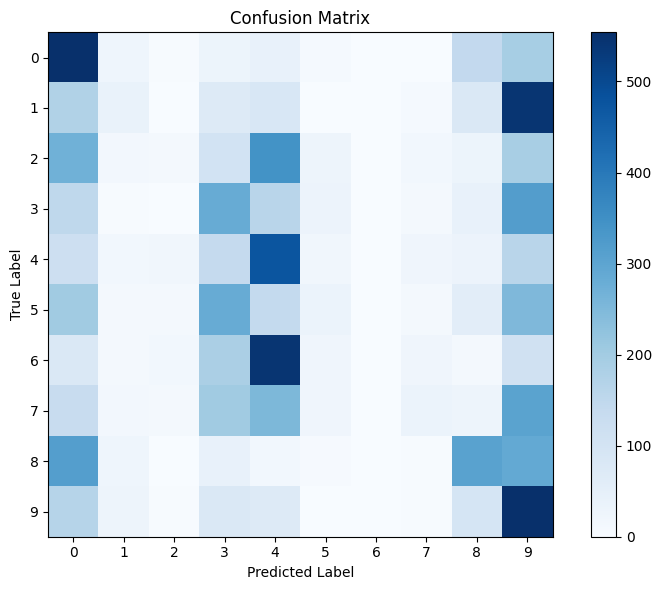

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)  # Assuming 10 classes
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ROC Curves for Multi-Class (One-vs-All)

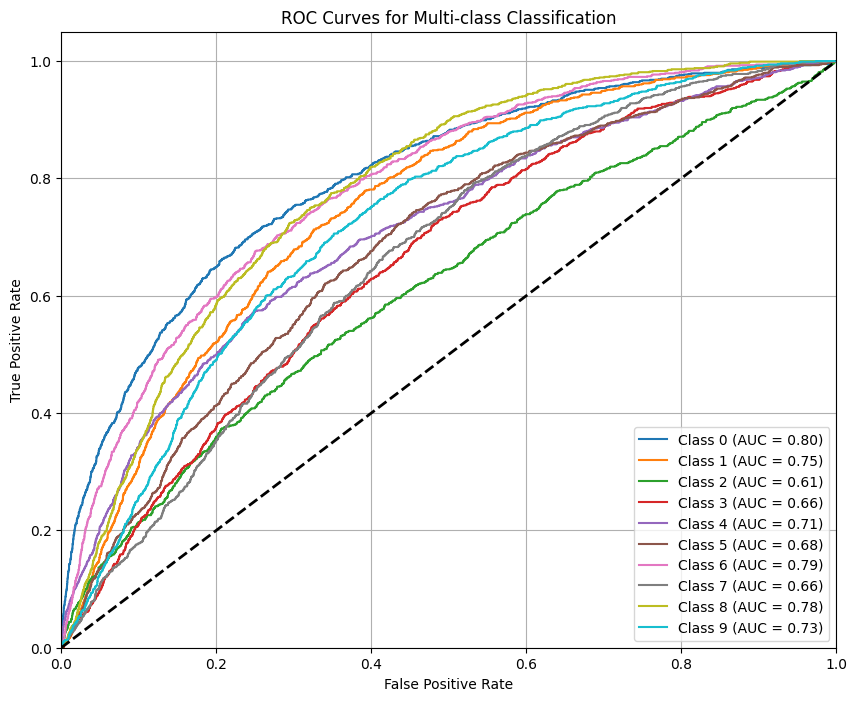

In [ ]:
n_classes = 10  # Change if you have a different number of classes.
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random chance.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-class Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()